# Библиотеки

In [1]:
!pip install -q catboost shap

     |████████████████████████████████| 76.1 MB 107.1 MB/s 
     |████████████████████████████████| 564 kB 71.9 MB/s 


In [2]:
!pip install -q imgaug==0.2.6
!pip install -q phik

     |████████████████████████████████| 631 kB 4.0 MB/s 
     |████████████████████████████████| 675 kB 4.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 


In [254]:
import numpy as np
from numpy import std
from numpy import mean
import pandas as pd
from pandas.api.types import CategoricalDtype

import catboost
from lightgbm import LGBMRegressor
import shap

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error, r2_score

import phik
from phik import report
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

from typing import Optional, List

import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 50)

# Пользовательские функции

In [4]:
def get_features_per_types(data_frame):

    numeric_columns = []
    object_columns = []
    categorial_columns = []
    mixed_columns = []

    for column in data_frame.columns:
        if pd.Index(data_frame[column]).is_numeric():
            numeric_columns.append(column)
        elif pd.Index(data_frame[column]).is_object():
            object_columns.append(column)
        elif pd.Index(data_frame[column]).is_categorial():
            categorial_columns.append(column)
        elif pd.Index(data_frame[column]).is_mixed():
            mixed_columns.append(column)

    return numeric_columns, object_columns, categorial_columns, mixed_columns

In [5]:
def features_category(feature, binary_features_list, unordered_car_features_list, ordered_cat_features_list, numeric_features_list):
    if feature in binary_features_list:
        return 'Тип: Binary'
    elif feature in unordered_car_features_list:
        return 'Тип: Unordered'
    elif feature in ordered_cat_features_list:
        return 'Тип: Ordered'
    elif feature in numeric_features_list:
        return 'Тип: Numeric'

In [6]:
def plot_histwithkde_scatter_to_target(
    data: pd.DataFrame, 
    feature: str, 
    target: str, 
    hue=None, 
    nrows=1, ncols=2, 
    figsize=(15,7),
    linewidth=3, bins=50, bw_adjust=0.5, 
    loc='upper center', anchored_text=True
    ):

    sns.set_style('whitegrid')
    sns.set_context(rc = {'lines.linewidth': linewidth})

    if feature != target:
        fig, ax = plt.subplots(nrows, ncols, figsize=figsize, sharey=False)
        sct = sns.scatterplot(
            data=data,
            x=feature, 
            y=target,
            hue=hue,
            ax=ax[1])
        ax_hst = ax[0]
    else:
        fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
        ax_hst = ax

    hst = sns.histplot(
        data=data,
        x=feature, 
        stat='density', 
        bins=bins, 
        legend=True, 
        kde=True,
        kde_kws={'bw_adjust': bw_adjust}, 
        ax=ax_hst)

    if anchored_text:
        at = AnchoredText(
            str(round(data[feature].describe(), 0)).split('Name')[0], 
            prop=dict(size=12), 
            frameon=False, 
            loc=loc)
        ax_hst.add_artist(at)

    plt.tight_layout()
    sns.despine()

In [7]:
def plot_scatters_to_target(
    data: pd.DataFrame, 
    features: List, 
    target: str, 
    nrows: int,
    ncols: int,
    hue=None, 
    figsize=(15,7),
    linewidth=3, bins=50, bw_adjust=0.5, 
    loc='upper center',
    sharey=False
    ):

    sns.set_style('whitegrid')
    sns.set_context(rc = {'lines.linewidth': linewidth})
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, sharey=sharey)

    for i, f in enumerate(features):
        if nrows != 1:
            ax_hst=ax[i//ncols, i%ncols]
        else:
            ax_hst=ax[i%ncols]

        hst = sns.scatterplot(
            data=data,
            x=f, 
            y=target,
            hue=hue,
            ax=ax_hst)

    plt.tight_layout()
    sns.despine()

In [8]:
def plot_scatter_for_nfeatures(
    data: pd.DataFrame, 
    features: List, 
    nrows: int,
    ncols: int, 
    hue=None, 
    figsize=(15,7),
    loc='upper center', anchored_text=True,
    title=None
    ):

    sns.set_style('whitegrid')
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, sharey=False)

    for i, f in enumerate(features):
        sct = sns.scatterplot(
            data=data,
            x=f, 
            y=target, 
            hue=hue,
            ax=ax[i//ncols, i%ncols])
        sct.set_title(title)

        if anchored_text:
            at = AnchoredText(
                str(round(data[f].describe(), 0)).split('Name')[0], 
                prop=dict(size=12), 
                frameon=False, 
                loc=loc)
            ax[i//ncols, i%ncols].add_artist(at)

        plt.tight_layout()
        sns.despine()

In [9]:
def plot_histwithkde_for_nfeatures(
    data: pd.DataFrame, 
    features: List, 
    nrows: int,
    ncols: int, 
    hue=None, 
    figsize=(15,7),
    linewidth=3, bins=50, bw_adjust=0.5, 
    loc='upper center', anchored_text=True,
    title=None
    ):

    sns.set_style('whitegrid')
    sns.set_context(rc = {'lines.linewidth': linewidth})

    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, sharey=False)

    for i, f in enumerate(features):
        hst = sns.histplot(
            data=data,
            x=f, 
            stat='density', 
            bins=bins, 
            legend=True, 
            kde=True,
            hue=hue,
            kde_kws={'bw_adjust': bw_adjust}, 
            ax=ax[i//ncols, i%ncols])
        hst.set_title(title)

        if anchored_text:
            at = AnchoredText(
                str(round(data[f].describe(), 0)).split('Name')[0], 
                prop=dict(size=12), 
                frameon=False, 
                loc=loc)
            ax[i//ncols, i%ncols].add_artist(at)

        plt.tight_layout()
        sns.despine()

In [10]:
def masked_outlier(data: pd.DataFrame, factor: int, feature: str):
    upper_lim = data[feature].mean() + data[feature].std() * factor
    lower_lim = data[feature].mean() - data[feature].std() * factor
    hue = (data[feature] > upper_lim) | (data[feature] < lower_lim)
    return hue

In [11]:
def remove_outlier(data, feature, factor):
    upper_lim = data[feature].mean() + data[feature].std() * factor
    lower_lim = data[feature].mean() - data[feature].std() * factor
    data = data[(data[feature] < upper_lim) & (data[feature] > lower_lim)]
    return data

In [12]:
def remove_hicorr_features(data: pd.DataFrame, matrix: pd.DataFrame, threshold: int, target: str):
    
    y = data[target]
    data = data.drop(columns = [target])
    
    corr_matrix = matrix
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            if val >= threshold:
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])
            
    drops = set(drop_cols)
    data = data.drop(columns = drops)
            
    data[target] = y
               
    return data, drops

In [13]:
def plot_corr_matrix(
    matrix: pd.DataFrame,
    figsize: (int, int),
    cmap=sns.diverging_palette(245, 10, s=80, l=50, as_cmap=True),
    annot=True,
    fontsize=10,
    cbar_orient='horizontal',
    cbar=True
):
    if cbar:
        grid_kws = {"height_ratios": (.9, .01), "hspace": .16}
        f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=figsize)
    else:
        f, ax = plt.subplots(1, figsize=figsize)
        cbar_ax=None
        cbar_kws=None

    ax = sns.heatmap(
        matrix, 
        square=False, 
        cmap=cmap, 
        annot=annot, 
        fmt='.2f', 
        linewidths=.5, 
        ax=ax, 
        cbar=cbar,
        cbar_ax=cbar_ax, 
        cbar_kws={"orientation": cbar_orient},
        annot_kws={'fontsize': fontsize})

    plt.tight_layout()
    plt.show()

# **1. Загрузка данных**

In [388]:
df_train_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Занятие 10-11/Большое ДЗ 3/Новый датасет/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Занятие 10-11/Большое ДЗ 3/Новый датасет/test.csv')
sample_sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Занятие 10-11/Большое ДЗ 3/Новый датасет/sample_submission.csv')

In [15]:
df_train = df_train_original.copy()

Размер датасета:

In [16]:
df_train.shape

(30471, 292)

In [389]:
df_test.shape

(7662, 291)

Сэмпл датасета:

In [17]:
df_train.head(3)

id   timestamp  full_sq  ...  sport_count_5000  market_count_5000  price_doc
0   1  2011-08-20       43  ...                52                  4    5850000
1   2  2011-08-23       34  ...                66                 14    6000000
2   3  2011-08-27       43  ...                67                 10    5700000

[3 rows x 292 columns]

### Целевая переменная

In [18]:
target = 'price_doc'

# **2. Выделение признаков**

Общие сведения о признаках:

In [19]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 292 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   id                                     int64  
 1   timestamp                              object 
 2   full_sq                                int64  
 3   life_sq                                float64
 4   floor                                  float64
 5   max_floor                              float64
 6   material                               float64
 7   build_year                             float64
 8   num_room                               float64
 9   kitch_sq                               float64
 10  state                                  float64
 11  product_type                           object 
 12  sub_area                               object 
 13  area_m                                 float64
 14  raion_popul                            int64  
 15  g

Видиим, что признаки делятся только на два типа данных: числовые (int, float) и не числовые (object).

## Анализ категорий признаков

Необходимо определить категорий признаков (интервальные, бинарные, категориальные упорядоченные, категориальные неупорядоченные) и проверить на типы данных в них.

Получим списки признаков по категориям, полученных при загрузке датасета:

In [20]:
num_cols, obj_cols, cat_cols, mix_cols = get_features_per_types(df_train)

In [21]:
len(num_cols), len(obj_cols), len(cat_cols), len(mix_cols)

(276, 16, 0, 0)

Видим, что 276 признаков содержат числовые объекты и 16 признаков не числовые.

Проверим какие значения принимают не числовые признаки:

In [22]:
for f in obj_cols:
    print(f'{f}: {df_train[f].unique()}', '\n')

timestamp: ['2011-08-20' '2011-08-23' '2011-08-27' ... '2015-06-27' '2015-06-29'
 '2015-06-30'] 

product_type: ['Investment' 'OwnerOccupier'] 

sub_area: ['Bibirevo' 'Nagatinskij Zaton' "Tekstil'shhiki" 'Mitino' 'Basmannoe'
 'Nizhegorodskoe' "Sokol'niki" 'Koptevo' 'Kuncevo' 'Kosino-Uhtomskoe'
 'Zapadnoe Degunino' 'Presnenskoe' 'Lefortovo' "Mar'ino" "Kuz'minki"
 'Nagornoe' "Gol'janovo" 'Vnukovo' 'Juzhnoe Tushino' 'Severnoe Tushino'
 "Chertanovo Central'noe" 'Fili Davydkovo' 'Otradnoe' 'Novo-Peredelkino'
 'Bogorodskoe' 'Jaroslavskoe' 'Strogino' 'Hovrino' "Moskvorech'e-Saburovo"
 'Staroe Krjukovo' 'Ljublino' 'Caricyno' 'Veshnjaki' 'Danilovskoe'
 'Preobrazhenskoe' "Kon'kovo" 'Brateevo' 'Vostochnoe Izmajlovo'
 'Vyhino-Zhulebino' 'Donskoe' 'Novogireevo' 'Juzhnoe Butovo' 'Sokol'
 'Kurkino' 'Izmajlovo' 'Severnoe Medvedkovo' 'Rostokino'
 'Orehovo-Borisovo Severnoe' 'Ochakovo-Matveevskoe' 'Taganskoe'
 'Dmitrovskoe' 'Orehovo-Borisovo Juzhnoe' 'Teplyj Stan' 'Babushkinskoe'
 'Pokrovskoe Streshnevo

Проверим какие значения принимают числовые признаки:

In [23]:
for f in num_cols:
    print(f'{f}: {df_train[f].unique()}', '\n')

id: [    1     2     3 ... 30471 30472 30473] 

full_sq: [  43   34   89   77   67   25   44   42   36   38   31   51   47   59
   74   39   48   32   45   35   73   40   81   37   27   33   54   46
   56   75   64   96   52   63   50   76   66   30   53  133   72   41
   26   58   78   57   61  325   55   22   62  102  117   60   86   85
  115   98   80   68   49  104   84   17   93   99  144   83   20  154
   79   71   28   70   23   90  100  129  130   95  111  131  108   82
  126  112  110   92   29  125  106   87   12   97  167  114  118  136
  166  120  123   65  183  155  101  204   88   94  107   13  147   69
  169  127    9   19  103  291   15  353  187  142  137  394  113  148
   18    5  134  173  412  105  178  119  138  729  156  139  164   21
  172 5326  208  150  157  388  159  158   10  170  165  109  193   24
  181  140  179   91  210  143  634  116  121    6  211  122  206  149
  124  461  185  146   14   11  141  226  160  132    1  202   16  135
  215  174  153  303

Видим, что следующие признаки являются бинарными:
```
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
```

Признаки категориальные неупорядоченные:
```
sub_area
material
ID_metro
ID_railroad_station_walk
ID_railroad_station_avto
ID_big_road1
ID_big_road2
ID_railroad_terminal
ID_bus_terminal
```

Признаки категориальные упорядоченные:
```
ecology
state
```

Признак ```timestamp``` типа ```datetime```, но разобъем его на три числовых (предполагая зависимости целевой переменной отдельно от года, месяца и дня сделки):
```
year_trans
month_trans
day_trans
```


Признаки числовые:
```
full_sq
life_sq
floor
max_floor
build_year
num_room
kitch_sq
area_m
raion_popul
green_zone_part
indust_part
children_preschool
preschool_quota
preschool_education_centers_raion
children_school
school_quota
school_education_centers_raion
school_education_centers_top_20_raion
hospital_beds_raion
healthcare_centers_raion
university_top_20_raion
sport_objects_raion
additional_education_raion
culture_objects_top_25_raion
shopping_centers_raion
office_raion
full_all
male_f
female_f
young_all
young_male
young_female
work_all
work_male
work_female
ekder_all
ekder_male
ekder_female
0_6_all
0_6_male
0_6_female
7_14_all
7_14_male
7_14_female
0_17_all
0_17_male
0_17_female
16_29_all
16_29_male
16_29_female
0_13_all
0_13_male
0_13_female
raion_build_count_with_material_info
build_count_block
build_count_wood
build_count_frame
build_count_brick
build_count_monolith
build_count_panel
build_count_foam
build_count_slag
build_count_mix
raion_build_count_with_builddate_info
build_count_before_1920
build_count_1921-1945
build_count_1946-1970
build_count_1971-1995
build_count_after_1995
metro_min_avto
metro_km_avto
metro_min_walk
metro_km_walk
kindergarten_km
school_km
park_km
green_zone_km
industrial_km
water_treatment_km
cemetery_km
incineration_km
railroad_station_walk_km
railroad_station_walk_min
railroad_station_avto_km
railroad_station_avto_min
public_transport_station_km
public_transport_station_min_walk
water_km
mkad_km
ttk_km
sadovoe_km
bulvar_ring_km
kremlin_km
big_road1_km
big_road2_km
railroad_km
zd_vokzaly_avto_km
bus_terminal_avto_km
oil_chemistry_km
nuclear_reactor_km
radiation_km
power_transmission_line_km
thermal_power_plant_km
ts_km
big_market_km
market_shop_km
fitness_km
swim_pool_km
ice_rink_km
stadium_km
basketball_km
hospice_morgue_km
detention_facility_km
public_healthcare_km
university_km
workplaces_km
shopping_centers_km
office_km
additional_education_km
preschool_km
big_church_km
church_synagogue_km
mosque_km
theater_km
museum_km
exhibition_km
catering_km
green_part_500
prom_part_500
office_count_500
office_sqm_500
trc_count_500
trc_sqm_500
cafe_count_500
cafe_sum_500_min_price_avg
cafe_sum_500_max_price_avg
cafe_avg_price_500
cafe_count_500_na_price
cafe_count_500_price_500
cafe_count_500_price_1000
cafe_count_500_price_1500
cafe_count_500_price_2500
cafe_count_500_price_4000
cafe_count_500_price_high
big_church_count_500
church_count_500
mosque_count_500
leisure_count_500
sport_count_500
market_count_500
green_part_1000
prom_part_1000
office_count_1000
office_sqm_1000
trc_count_1000
trc_sqm_1000
cafe_count_1000
cafe_sum_1000_min_price_avg
cafe_sum_1000_max_price_avg
cafe_avg_price_1000
cafe_count_1000_na_price
cafe_count_1000_price_500
cafe_count_1000_price_1000
cafe_count_1000_price_1500
cafe_count_1000_price_2500
cafe_count_1000_price_4000
cafe_count_1000_price_high
big_church_count_1000
church_count_1000
mosque_count_1000
leisure_count_1000
sport_count_1000
market_count_1000
green_part_1500
prom_part_1500
office_count_1500
office_sqm_1500
trc_count_1500
trc_sqm_1500
cafe_count_1500
cafe_sum_1500_min_price_avg
cafe_sum_1500_max_price_avg
cafe_avg_price_1500
cafe_count_1500_na_price
cafe_count_1500_price_500
cafe_count_1500_price_1000
cafe_count_1500_price_1500
cafe_count_1500_price_2500
cafe_count_1500_price_4000
cafe_count_1500_price_high
big_church_count_1500
church_count_1500
mosque_count_1500
leisure_count_1500
sport_count_1500
market_count_1500
green_part_2000
prom_part_2000
office_count_2000
office_sqm_2000
trc_count_2000
trc_sqm_2000
cafe_count_2000
cafe_sum_2000_min_price_avg
cafe_sum_2000_max_price_avg
cafe_avg_price_2000
cafe_count_2000_na_price
cafe_count_2000_price_500
cafe_count_2000_price_1000
cafe_count_2000_price_1500
cafe_count_2000_price_2500
cafe_count_2000_price_4000
cafe_count_2000_price_high
big_church_count_2000
church_count_2000
mosque_count_2000
leisure_count_2000
sport_count_2000
market_count_2000
green_part_3000
prom_part_3000
office_count_3000
office_sqm_3000
trc_count_3000
trc_sqm_3000
cafe_count_3000
cafe_sum_3000_min_price_avg
cafe_sum_3000_max_price_avg
cafe_avg_price_3000
cafe_count_3000_na_price
cafe_count_3000_price_500
cafe_count_3000_price_1000
cafe_count_3000_price_1500
cafe_count_3000_price_2500
cafe_count_3000_price_4000
cafe_count_3000_price_high
big_church_count_3000
church_count_3000
mosque_count_3000
leisure_count_3000
sport_count_3000
market_count_3000
green_part_5000
prom_part_5000
office_count_5000
office_sqm_5000
trc_count_5000
trc_sqm_5000
cafe_count_5000
cafe_sum_5000_min_price_avg
cafe_sum_5000_max_price_avg
cafe_avg_price_5000
cafe_count_5000_na_price
cafe_count_5000_price_500
cafe_count_5000_price_1000
cafe_count_5000_price_1500
cafe_count_5000_price_2500
cafe_count_5000_price_4000
cafe_count_5000_price_high
big_church_count_5000
church_count_5000
mosque_count_5000
leisure_count_5000
sport_count_5000
market_count_5000
price_doc
```

## Итоговые категории признаков

Таким образом сформированы категории признаков:

In [24]:
binary_features = ['culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion',
                   'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
                   'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
                   'water_1line', 'big_road1_1line', 'railroad_1line', 'product_type']

In [25]:
ordered_cat_features = {
    'ecology': ['no data', 'poor', 'satisfactory', 'good', 'excellent'],
    'state': [0, 1, 2, 3, 4]
    }

In [26]:
unordered_cat_teatures = ['sub_area', 'material', 'ID_metro', 'ID_railroad_station_walk', 
                          'ID_railroad_station_avto', 'ID_big_road1', 'ID_big_road2',
                          'ID_railroad_terminal', 'ID_bus_terminal']

In [27]:
numeric_features = list(set(df_train.columns.to_list()).difference(set([*binary_features, *ordered_cat_features.keys(), *unordered_cat_teatures, target, 'id'])))

In [28]:
all_features = list(set([*binary_features, *ordered_cat_features.keys(), *unordered_cat_teatures, *numeric_features]))

При дальнейшей обработке приведем данные в признаках к типам, соответсвующим их категориям.

На данном этапе преобразовать типы мы не можем из-за пропусков в данных (значения Nan), нам для этого нужно их заполнить.

# **3. Анализ пропусков**



In [29]:
features_with_na = df_train.isna().sum().where(df_train.isna().sum() > 0).dropna().to_frame('NA_count').reset_index()
features_with_na['NA_ratio'] = round(features_with_na['NA_count'] / df_train.shape[0], 3)
features_with_na.rename(columns={'index': 'feature'}, inplace=True)

In [30]:
features_with_na

feature  NA_count  NA_ratio
0                       life_sq    6383.0     0.209
1                         floor     167.0     0.005
2                     max_floor    9572.0     0.314
3                      material    9572.0     0.314
4                    build_year   13605.0     0.446
..                          ...       ...       ...
46          cafe_avg_price_3000     991.0     0.033
47               prom_part_5000     178.0     0.006
48  cafe_sum_5000_min_price_avg     297.0     0.010
49  cafe_sum_5000_max_price_avg     297.0     0.010
50          cafe_avg_price_5000     297.0     0.010

[51 rows x 3 columns]

In [31]:
print(features_with_na[(features_with_na.NA_ratio > 0.1) & features_with_na.NA_ratio <= 0.1].shape[0])
features_with_na[features_with_na.NA_ratio > 0.1]

35


feature  NA_count  NA_ratio
0                                 life_sq    6383.0     0.209
2                               max_floor    9572.0     0.314
3                                material    9572.0     0.314
4                              build_year   13605.0     0.446
5                                num_room    9572.0     0.314
6                                kitch_sq    9572.0     0.314
7                                   state   13559.0     0.445
8                         preschool_quota    6688.0     0.219
9                            school_quota    6685.0     0.219
10                    hospital_beds_raion   14441.0     0.474
11   raion_build_count_with_material_info    4991.0     0.164
12                      build_count_block    4991.0     0.164
13                       build_count_wood    4991.0     0.164
14                      build_count_frame    4991.0     0.164
15                      build_count_brick    4991.0     0.164
16                   build_count_monolith    4991.0     0.164
17                      build_count_panel    4991.0     0.164
18                       build_count_foam    4991.0     0.164
19                       build_count_slag    4991.0     0.164
20                        build_count_mix    4991.0     0.164
21  raion_build_count_with_builddate_info    4991.0     0.164
22                build_count_before_1920    4991.0     0.164
23                  build_count_1921-1945    4991.0     0.164
24                  build_count_1946-1970    4991.0     0.164
25                  build_count_1971-1995    4991.0     0.164
26                 build_count_after_1995    4991.0     0.164
32             cafe_sum_500_min_price_avg   13281.0     0.436
33             cafe_sum_500_max_price_avg   13281.0     0.436
34                     cafe_avg_price_500   13281.0     0.436
35            cafe_sum_1000_min_price_avg    6524.0     0.214
36            cafe_sum_1000_max_price_avg    6524.0     0.214
37                    cafe_avg_price_1000    6524.0     0.214
38            cafe_sum_1500_min_price_avg    4199.0     0.138
39            cafe_sum_1500_max_price_avg    4199.0     0.138
40                    cafe_avg_price_1500    4199.0     0.138

In [32]:
print(features_with_na[features_with_na.NA_ratio >= 0.4].shape[0])
features_with_na[features_with_na.NA_ratio >= 0.4]

6


feature  NA_count  NA_ratio
4                   build_year   13605.0     0.446
7                        state   13559.0     0.445
10         hospital_beds_raion   14441.0     0.474
32  cafe_sum_500_min_price_avg   13281.0     0.436
33  cafe_sum_500_max_price_avg   13281.0     0.436
34          cafe_avg_price_500   13281.0     0.436

Видим, что 51 признак с пропусками и 35 признаков со значительным количеством пропусков, при этом 6 из них почти c 50% количеством пропусков.

## Признаки с ~50% количеством пропусков

Рассмотрим распределения их значений:

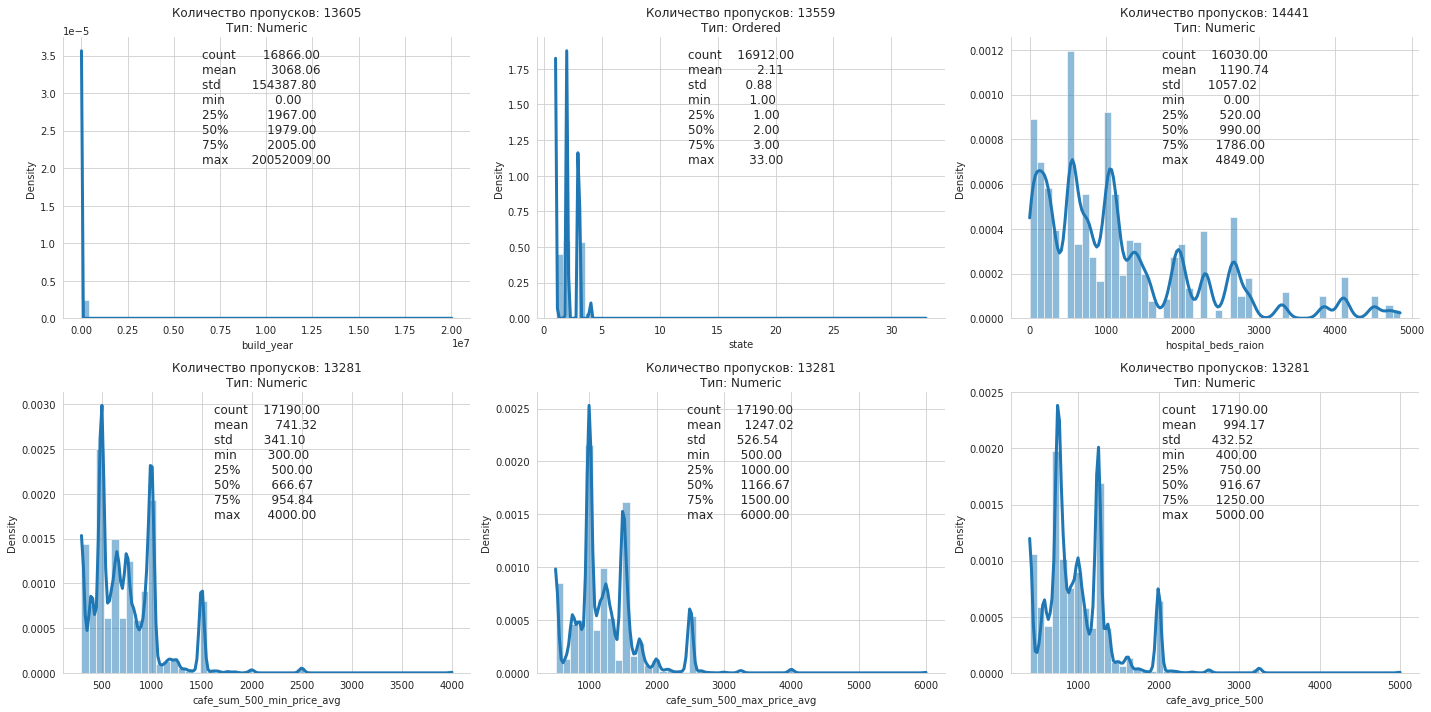

In [33]:
sns.set_style('whitegrid')
sns.set_context(rc = {'lines.linewidth': 3})
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=False)

for i, f in enumerate(features_with_na[features_with_na.NA_ratio > 0.4]['feature']):
    hst = sns.histplot(
        data=df_train,
        x=f, 
        stat='density', 
        bins=50, 
        legend=True, 
        kde=True,
        kde_kws={'bw_adjust': 0.5}, 
        ax=ax[i//3, i%3])
    # hst.set_title(f"Количество пропусков: {int(features_with_na[features_with_na['feature'] == f]['NA_count'].iloc[0])}")
    hst.set_title(f"Количество пропусков: {int(features_with_na[features_with_na['feature'] == f]['NA_count'].iloc[0])}\n{features_category(f, binary_features, unordered_cat_teatures, ordered_cat_features, numeric_features)}")


    at = AnchoredText(
        str(round(df_train[f].describe(), 2)).split('Name')[0], 
        prop=dict(size=12), 
        frameon=False, 
        loc='upper center')
    ax[i//3, i%3].add_artist(at)

plt.tight_layout()
sns.despine()

Рассмотрим подробно данные признаки

####  **Признак build_year**

В признаке года постройки видны ошибки заполнения:

In [34]:
df_train[(df_train['build_year'] > 2022) | (df_train['build_year'] < 1900)]['build_year'].astype(int).value_counts(sort=False)

0           530
1           368
3             2
20            1
20052009      1
71            1
215           1
1691          1
1860          2
1876          1
1886          1
1890          5
4965          1
1895          1
1896          2
Name: build_year, dtype: int64

Два дома из далекого будущего:

In [35]:
temp_df_1 = df_train[df_train['build_year'].isin([4965, 20052009])].loc[:, ['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 
                                                                          'build_year', 'state', 'sub_area', 'price_doc']].sort_values(by='price_doc')
temp_df_1

id  full_sq  life_sq  ...  state         sub_area  price_doc
15220  15223       41     24.0  ...    3.0  Sokolinaja Gora    8400000
10089  10092       37     16.0  ...   33.0      Cheremushki    9000000

[2 rows x 9 columns]

Очевидно это ошибка набора, в первом случае вероятно ошибка в первой цифре - заменим на 1965, а во втором - на 2009.

Дом из глубокого прошлого:

In [36]:
df_train[df_train['build_year'] == 1691]

id   timestamp  ...  market_count_5000  price_doc
26332  26335  2014-12-12  ...                  6    6250000

[1 rows x 292 columns]

Здесь также очень вероятна ошибка заполнения, т.к. с 17-го по 19-й век в Москве был лишь один 5-этажный дом, навряд ли это он https://zen.yandex.ru/media/linder_historia/starye-neboskreby-moskvy-kto-vyshe-5f96a8e924d0d15a66940350

Дома 19-го века:

In [37]:
temp_df_2 = df_train[df_train['build_year'].isin([1860, 1876, 1886, 
                                                  1890, 1895, 1896])].loc[:, ['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 
                                                                              'build_year', 'state', 'sub_area', 'price_doc']].sort_values(by='price_doc')
temp_df_2

id  full_sq  life_sq  ...  state        sub_area  price_doc
19541  19544       55     30.0  ...    NaN       Lefortovo    1200000
16581  16584       42     25.0  ...    4.0  Krasnosel'skoe    2000000
27751  27754       30     13.0  ...    2.0     Danilovskoe    2000000
14158  14161       37     19.0  ...    2.0       Kuz'minki    6200000
23117  23120       55     30.0  ...    2.0       Lefortovo    9000000
15282  15285       53     34.0  ...    3.0     Danilovskoe    9700000
18079  18082       61     29.0  ...    2.0     Presnenskoe   10850000
17212  17215       50     25.0  ...    2.0     Meshhanskoe   10950000
12068  12071       70     46.0  ...    3.0     Danilovskoe   11000000
23174  23177       44     29.0  ...    3.0  Krasnosel'skoe   12500000
18933  18936      177    119.0  ...    2.0       Basmannoe   24267600
29517  29520      187    139.0  ...    4.0       Hamovniki   42300000

[12 rows x 9 columns]

Достоверность этих данных тоже вызывает сомнения, очень маленькая выборка, всего 12 домов из 30-тысячного датасета. Опять же 16-этажный дом в 1860 году...

Поэтому заменим все эти значения:

In [38]:
df_train.loc[10089, 'build_year'] = 2009
df_train.loc[15220, 'build_year'] = 1965
df_train.loc[26332, 'build_year'] = 1991
df_train.loc[temp_df_2.index, 'build_year'] += 100

In [39]:
temp_list = temp_df_2.index.to_list()
temp_list.extend([10089, 15220, 26332])
df_train.loc[temp_list, 'build_year']

19541    1990.0
16581    1995.0
27751    1960.0
14158    1960.0
23117    1990.0
15282    1996.0
18079    1990.0
17212    1976.0
12068    1996.0
23174    1990.0
18933    1990.0
29517    1986.0
10089    2009.0
15220    1965.0
26332    1991.0
Name: build_year, dtype: float64

Дома от начала времен:

In [40]:
df_train[df_train['build_year'] < 1600].loc[:, ['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 
                                                'build_year', 'state', 'sub_area', 'price_doc']].sort_values(by='price_doc')

id  full_sq  life_sq  ...  state                   sub_area  price_doc
22782  22785       82     82.0  ...    3.0       Ochakovo-Matveevskoe    1100000
29494  29497       57     29.0  ...    2.0             Timirjazevskoe    1200000
29871  29874       44     29.0  ...    3.0                    Zjuzino    1600000
14534  14537       34     34.0  ...    NaN  Poselenie Novofedorovskoe    1740000
30225  30228       34     34.0  ...    1.0  Poselenie Novofedorovskoe    1915412
...      ...      ...      ...  ...    ...                        ...        ...
30150  30153      107      1.0  ...    1.0                    Ramenki   19420850
14570  14573      100    100.0  ...    1.0               Obruchevskoe   20272106
28132  28135       90      1.0  ...    1.0                Danilovskoe   23490000
21010  21013      119    119.0  ...    1.0                Presnenskoe   32652930
25304  25307      160    155.0  ...    1.0                Presnenskoe   36860612

[903 rows x 9 columns]

Здесь также видны очевидные несоответствия, при этом по части объектов видно, что скорее всего речь идет о земельных участках. Заменим для данных объектов год постройки на 0.

In [41]:
df_train.loc[df_train['build_year'] < 1600, ['build_year']] = 0

In [42]:
np.sort(df_train['build_year'].unique())

array([   0., 1900., 1904., 1905., 1906., 1907., 1910., 1911., 1912.,
       1914., 1915., 1917., 1920., 1924., 1925., 1926., 1927., 1928.,
       1929., 1930., 1931., 1932., 1933., 1934., 1935., 1936., 1937.,
       1938., 1939., 1940., 1941., 1943., 1946., 1947., 1948., 1949.,
       1950., 1951., 1952., 1953., 1954., 1955., 1956., 1957., 1958.,
       1959., 1960., 1961., 1962., 1963., 1964., 1965., 1966., 1967.,
       1968., 1969., 1970., 1971., 1972., 1973., 1974., 1975., 1976.,
       1977., 1978., 1979., 1980., 1981., 1982., 1983., 1984., 1985.,
       1986., 1987., 1988., 1989., 1990., 1991., 1992., 1993., 1994.,
       1995., 1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003.,
       2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011., 2012.,
       2013., 2014., 2015., 2016., 2017., 2018.,   nan])

Все значения в признаке исправлены.

Пропуски в дальнейшем заполним значением 0

#### **Признак state**

In [43]:
df_train['state'].value_counts()

2.0     5844
3.0     5790
1.0     4855
4.0      422
33.0       1
Name: state, dtype: int64

Здесь также видим ошибку набора:

In [44]:
df_train[df_train.state == df_train.state.max()]

id   timestamp  ...  market_count_5000  price_doc
10089  10092  2013-08-27  ...                 11    9000000

[1 rows x 292 columns]

Вероятно имелось в виду 3, заменим:

In [45]:
df_train.loc[10089, 'state'] = 3

Пропуски в дальнейшем заполним значением 0

#### **Признак hospital_beds_raion**

В данном признаке аномальных значений не наблюдается. Предположим, что количество больничных коек в районе можно взять из других строк, где они есть. Но при анализе выясняется, что таких районов нет, т.е. видимо по этим районам просто нет данных:

In [46]:
list_of_districts = df_train[df_train.hospital_beds_raion.isna()]['sub_area'].unique()
df_train[df_train.sub_area.isin(list_of_districts)]['hospital_beds_raion'].value_counts()

Series([], Name: hospital_beds_raion, dtype: int64)

Заполним их медианными значениями.

#### **Признаки cafe_sum_500_**

По трем признакам ```cafe_sum_500_*``` такая же ситуация, по этим районам нет данных:

In [47]:
list_of_districts_1 = df_train[df_train['cafe_sum_500_min_price_avg'].isna()]['sub_area'].unique()
list_of_districts_2 = df_train[df_train['cafe_sum_500_max_price_avg'].isna()]['sub_area'].unique()
list_of_districts_3 = df_train[df_train['cafe_avg_price_500'].isna()]['sub_area'].unique()

print(
    np.unique(list_of_districts_1 == list_of_districts_2),
    np.unique(list_of_districts_1 == list_of_districts_3)
)

[ True] [ True]


В отличии от признака количества больничных коек, которыми население обеспечивает государство и ведется соответствующая работа (т.е. они вероятнее есть, чем их нет), наличие кофеен в шаговой доступности определяется рыночными отношениями (т.е. их вероятнее нет, чем они есть, соответсвенно и чека за кофе), поэтому заполним пропуски нулями.

Произведем описанные замены:

In [48]:
df_train.build_year = df_train.build_year.fillna(0)
df_train.state = df_train.state.fillna(0)
df_train.loc[df_train.hospital_beds_raion.isna(), 'hospital_beds_raion'] = df_train['hospital_beds_raion'].median()
df_train.loc[df_train.cafe_sum_500_min_price_avg.isna(), 'cafe_sum_500_min_price_avg'] = 0
df_train.loc[df_train.cafe_sum_500_max_price_avg.isna(), 'cafe_sum_500_max_price_avg'] = 0
df_train.loc[df_train.cafe_avg_price_500.isna(), 'cafe_avg_price_500'] = 0

#### **Удалять или не удалять**

Т.к. в данных признаках очень много пропусков, вполне можно рассмотреть вариант их удаления. С другой стороны они могут обладать значительным влиянием на целевую переменную.

Посмотрим на зависимость целевой переменной от этих признаков:

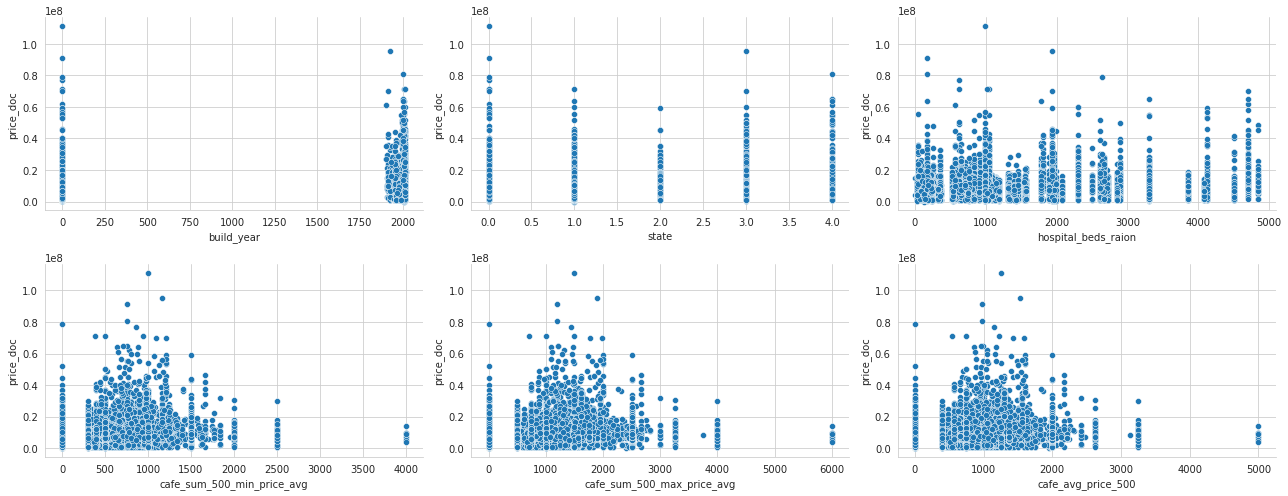

In [49]:
plot_scatter_for_nfeatures(
    data=df_train,
    features=features_with_na[features_with_na.NA_ratio > 0.4]['feature'],
    nrows=2, ncols=3, figsize=(18,7), anchored_text=False)

Визуально видно, что признак года постройки, определенно влияет - в целом новые дома стоят дороже.

В признаке состояния недвижимости интерсный разброс: объекты с плохим состоянием конкурируют с отличным. И в целом видна зависимость - объекты в хорошем состоянии стоят дороже.

По признаку кофеен нельзя сказать, что чем выше чек, тем дороже объект, или наоборот. Но возможно есть зависимость в области средних значений.

Попробуем оценить статистическую значимость влияния этих признаков на целевую переменную с помощью Z-оценки, учитывающей критерий p-значения:

$$Z = \Phi^{-1}(1-p)\ ;\quad \Phi(z)=\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{z} e^{-t^{2}/2}\,{\rm d}t $$

на первоначальном датасете.

In [50]:
def outlier_signifs(data, feature_1, feature_2, figsize):
    outlier_signifs = phik.outlier_significance_matrix(data.loc[:, [ feature_1, feature_2]], dropna=False)

    zvalues = outlier_signifs.values
    xlabels = outlier_signifs.columns
    ylabels = outlier_signifs.index
    xlabel = feature_2
    ylabel = feature_1

    plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                            x_label=xlabel,y_label=ylabel,
                            vmin=-5, vmax=5, 
                            title=f"\n\n\
                            Outlier significance for feautures\
                            \n {feature_1}  and  {feature_2} \n",
                            identity_layout=False, fontsize_factor=1,
                            figsize=figsize)


interval columns not set, guessing: ['price_doc', 'build_year']


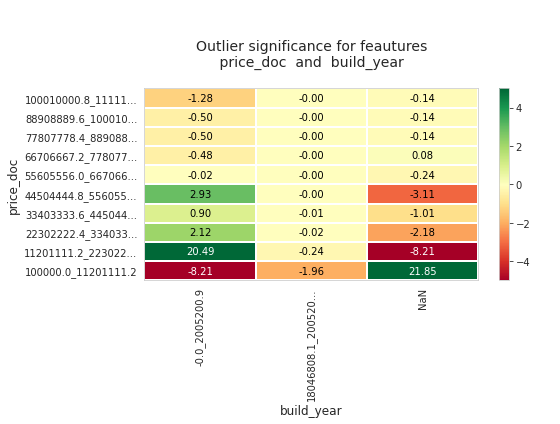

In [51]:
outlier_signifs(df_train_original, target, 'build_year', (8,6))

Расчет показывает, что пропуски в признаке года постройки значимо влияют на целевую переменную в ее диапазоне от миллиона до миллиона ста двадцати тысяч рублей. Т.е. в области девешых объектов, что косвенно подтверждает нашу гипотезу о старых домах в пропусках.

In [52]:
df_train_original[df_train_original.build_year.isna() & (df_train_original[target] >= 1000000) & (df_train_original[target] <= 11201111)].shape[0]

12427

И таких объектов чуть меньше половины датасета, удалив которые мы потеряем возможность обучить модель в данном диапазоне цен.

В признаке количества больничных коеек аналогично:

interval columns not set, guessing: ['price_doc', 'hospital_beds_raion']


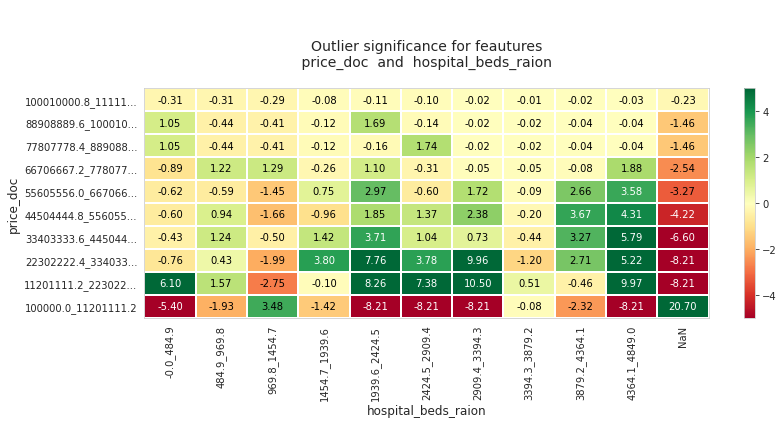

In [53]:
outlier_signifs(df_train_original, target, 'hospital_beds_raion', (12,6))

In [54]:
df_train_original[df_train_original.hospital_beds_raion.isna() & (df_train_original[target] >= 1000000) & (df_train_original[target] <= 11201111)].shape[0]

13218

Также слишком много объектов в нижнем диапазоне.

И в признаках средних кофе-чеков такая же ситуация, тотже диапазон и слишком много значений:

interval columns not set, guessing: ['price_doc', 'cafe_avg_price_500']
interval columns not set, guessing: ['price_doc', 'cafe_sum_500_min_price_avg']
interval columns not set, guessing: ['price_doc', 'cafe_sum_500_max_price_avg']


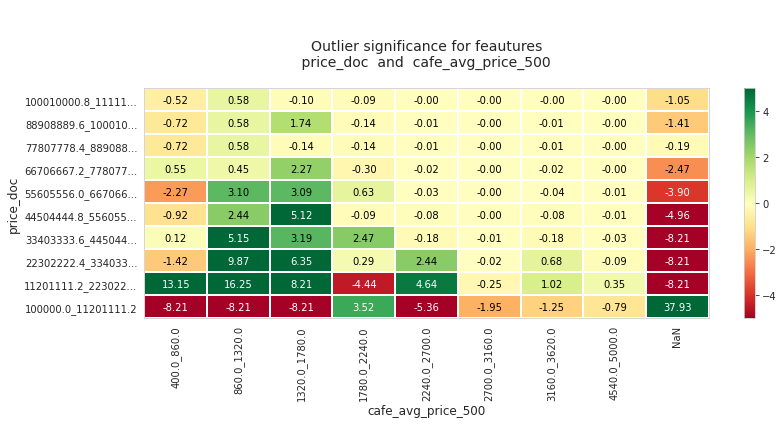

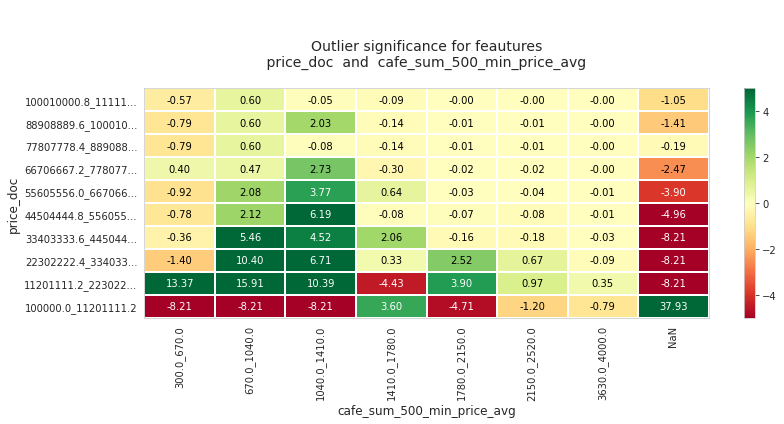

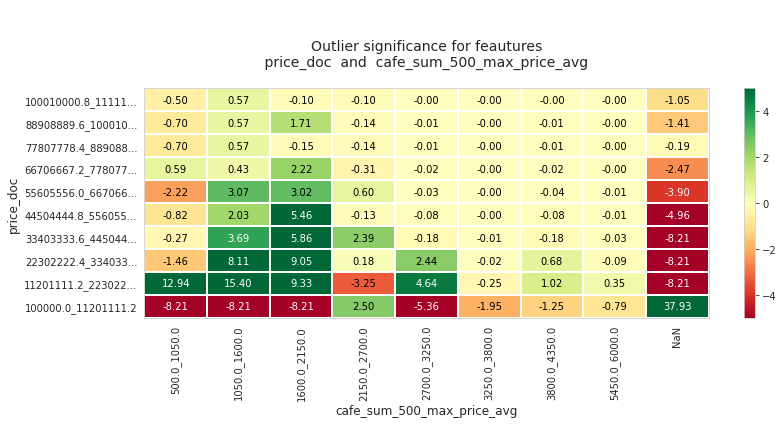

In [55]:
for _ in ['cafe_avg_price_500', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg']:
    outlier_signifs(df_train_original, target, _, (12,6))

In [56]:
print(
    df_train_original[df_train_original.cafe_avg_price_500.isna() & (df_train_original[target] >= 1000000) & (df_train_original[target] <= 11201111)].shape[0],
    df_train_original[df_train_original.cafe_sum_500_min_price_avg.isna() & (df_train_original[target] >= 1000000) & (df_train_original[target] <= 11201111)].shape[0],
    df_train_original[df_train_original.cafe_sum_500_max_price_avg.isna() & (df_train_original[target] >= 1000000) & (df_train_original[target] <= 11201111)].shape[0]
)

12542 12542 12542


Поэтому принято решение не удалять данные признаки.

Также при рассмотрении таблиц статистической значимости признака средних кофе-чеков выявилось, что все три признака идентичны по характеру влияния на целевую перменную, но с небольшими отличиями в некоторых областях цен. Возможно все три признака использовать избыточно, т.к. датасет содержит можество подобных "тройных" признаков. 

## **Остальные признаки с пропусками**

Признаки с большим количеством пропусков:

In [57]:
df_train.isna().sum().where(df_train.isna().sum() > 0).dropna().to_frame('NA_count').reset_index()

index  NA_count
0                                 life_sq    6383.0
1                                   floor     167.0
2                               max_floor    9572.0
3                                material    9572.0
4                                num_room    9572.0
5                                kitch_sq    9572.0
6                         preschool_quota    6688.0
7                            school_quota    6685.0
8    raion_build_count_with_material_info    4991.0
9                       build_count_block    4991.0
10                       build_count_wood    4991.0
11                      build_count_frame    4991.0
12                      build_count_brick    4991.0
13                   build_count_monolith    4991.0
14                      build_count_panel    4991.0
15                       build_count_foam    4991.0
16                       build_count_slag    4991.0
17                        build_count_mix    4991.0
18  raion_build_count_with_builddate_info    4991.0
19                build_count_before_1920    4991.0
20                  build_count_1921-1945    4991.0
21                  build_count_1946-1970    4991.0
22                  build_count_1971-1995    4991.0
23                 build_count_after_1995    4991.0
24                         metro_min_walk      25.0
25                          metro_km_walk      25.0
26               railroad_station_walk_km      25.0
27              railroad_station_walk_min      25.0
28               ID_railroad_station_walk      25.0
29            cafe_sum_1000_min_price_avg    6524.0
30            cafe_sum_1000_max_price_avg    6524.0
31                    cafe_avg_price_1000    6524.0
32            cafe_sum_1500_min_price_avg    4199.0
33            cafe_sum_1500_max_price_avg    4199.0
34                    cafe_avg_price_1500    4199.0
35            cafe_sum_2000_min_price_avg    1725.0
36            cafe_sum_2000_max_price_avg    1725.0
37                    cafe_avg_price_2000    1725.0
38            cafe_sum_3000_min_price_avg     991.0
39            cafe_sum_3000_max_price_avg     991.0
40                    cafe_avg_price_3000     991.0
41                         prom_part_5000     178.0
42            cafe_sum_5000_min_price_avg     297.0
43            cafe_sum_5000_max_price_avg     297.0
44                    cafe_avg_price_5000     297.0

Пропуски остальных признаков:

In [58]:
print(features_with_na[features_with_na.NA_ratio < 0.4].shape[0])
features_with_na_2 = features_with_na[features_with_na.NA_ratio < 0.4].sort_values(by='NA_ratio', ascending=False).reset_index(drop=True)
features_with_na_2

45


feature  NA_count  NA_ratio
0                               max_floor    9572.0     0.314
1                                material    9572.0     0.314
2                                num_room    9572.0     0.314
3                                kitch_sq    9572.0     0.314
4                         preschool_quota    6688.0     0.219
5                            school_quota    6685.0     0.219
6                     cafe_avg_price_1000    6524.0     0.214
7             cafe_sum_1000_max_price_avg    6524.0     0.214
8             cafe_sum_1000_min_price_avg    6524.0     0.214
9                                 life_sq    6383.0     0.209
10                        build_count_mix    4991.0     0.164
11                 build_count_after_1995    4991.0     0.164
12                  build_count_1946-1970    4991.0     0.164
13                  build_count_1921-1945    4991.0     0.164
14                build_count_before_1920    4991.0     0.164
15  raion_build_count_with_builddate_info    4991.0     0.164
16                  build_count_1971-1995    4991.0     0.164
17                       build_count_slag    4991.0     0.164
18                      build_count_frame    4991.0     0.164
19                       build_count_foam    4991.0     0.164
20                      build_count_block    4991.0     0.164
21                       build_count_wood    4991.0     0.164
22   raion_build_count_with_material_info    4991.0     0.164
23                      build_count_brick    4991.0     0.164
24                   build_count_monolith    4991.0     0.164
25                      build_count_panel    4991.0     0.164
26                    cafe_avg_price_1500    4199.0     0.138
27            cafe_sum_1500_min_price_avg    4199.0     0.138
28            cafe_sum_1500_max_price_avg    4199.0     0.138
29                    cafe_avg_price_2000    1725.0     0.057
30            cafe_sum_2000_min_price_avg    1725.0     0.057
31            cafe_sum_2000_max_price_avg    1725.0     0.057
32                    cafe_avg_price_3000     991.0     0.033
33            cafe_sum_3000_max_price_avg     991.0     0.033
34            cafe_sum_3000_min_price_avg     991.0     0.033
35            cafe_sum_5000_max_price_avg     297.0     0.010
36            cafe_sum_5000_min_price_avg     297.0     0.010
37                    cafe_avg_price_5000     297.0     0.010
38                         prom_part_5000     178.0     0.006
39                                  floor     167.0     0.005
40                         metro_min_walk      25.0     0.001
41               ID_railroad_station_walk      25.0     0.001
42              railroad_station_walk_min      25.0     0.001
43               railroad_station_walk_km      25.0     0.001
44                          metro_km_walk      25.0     0.001

Рассмотрим распределения признаков с пропусками:

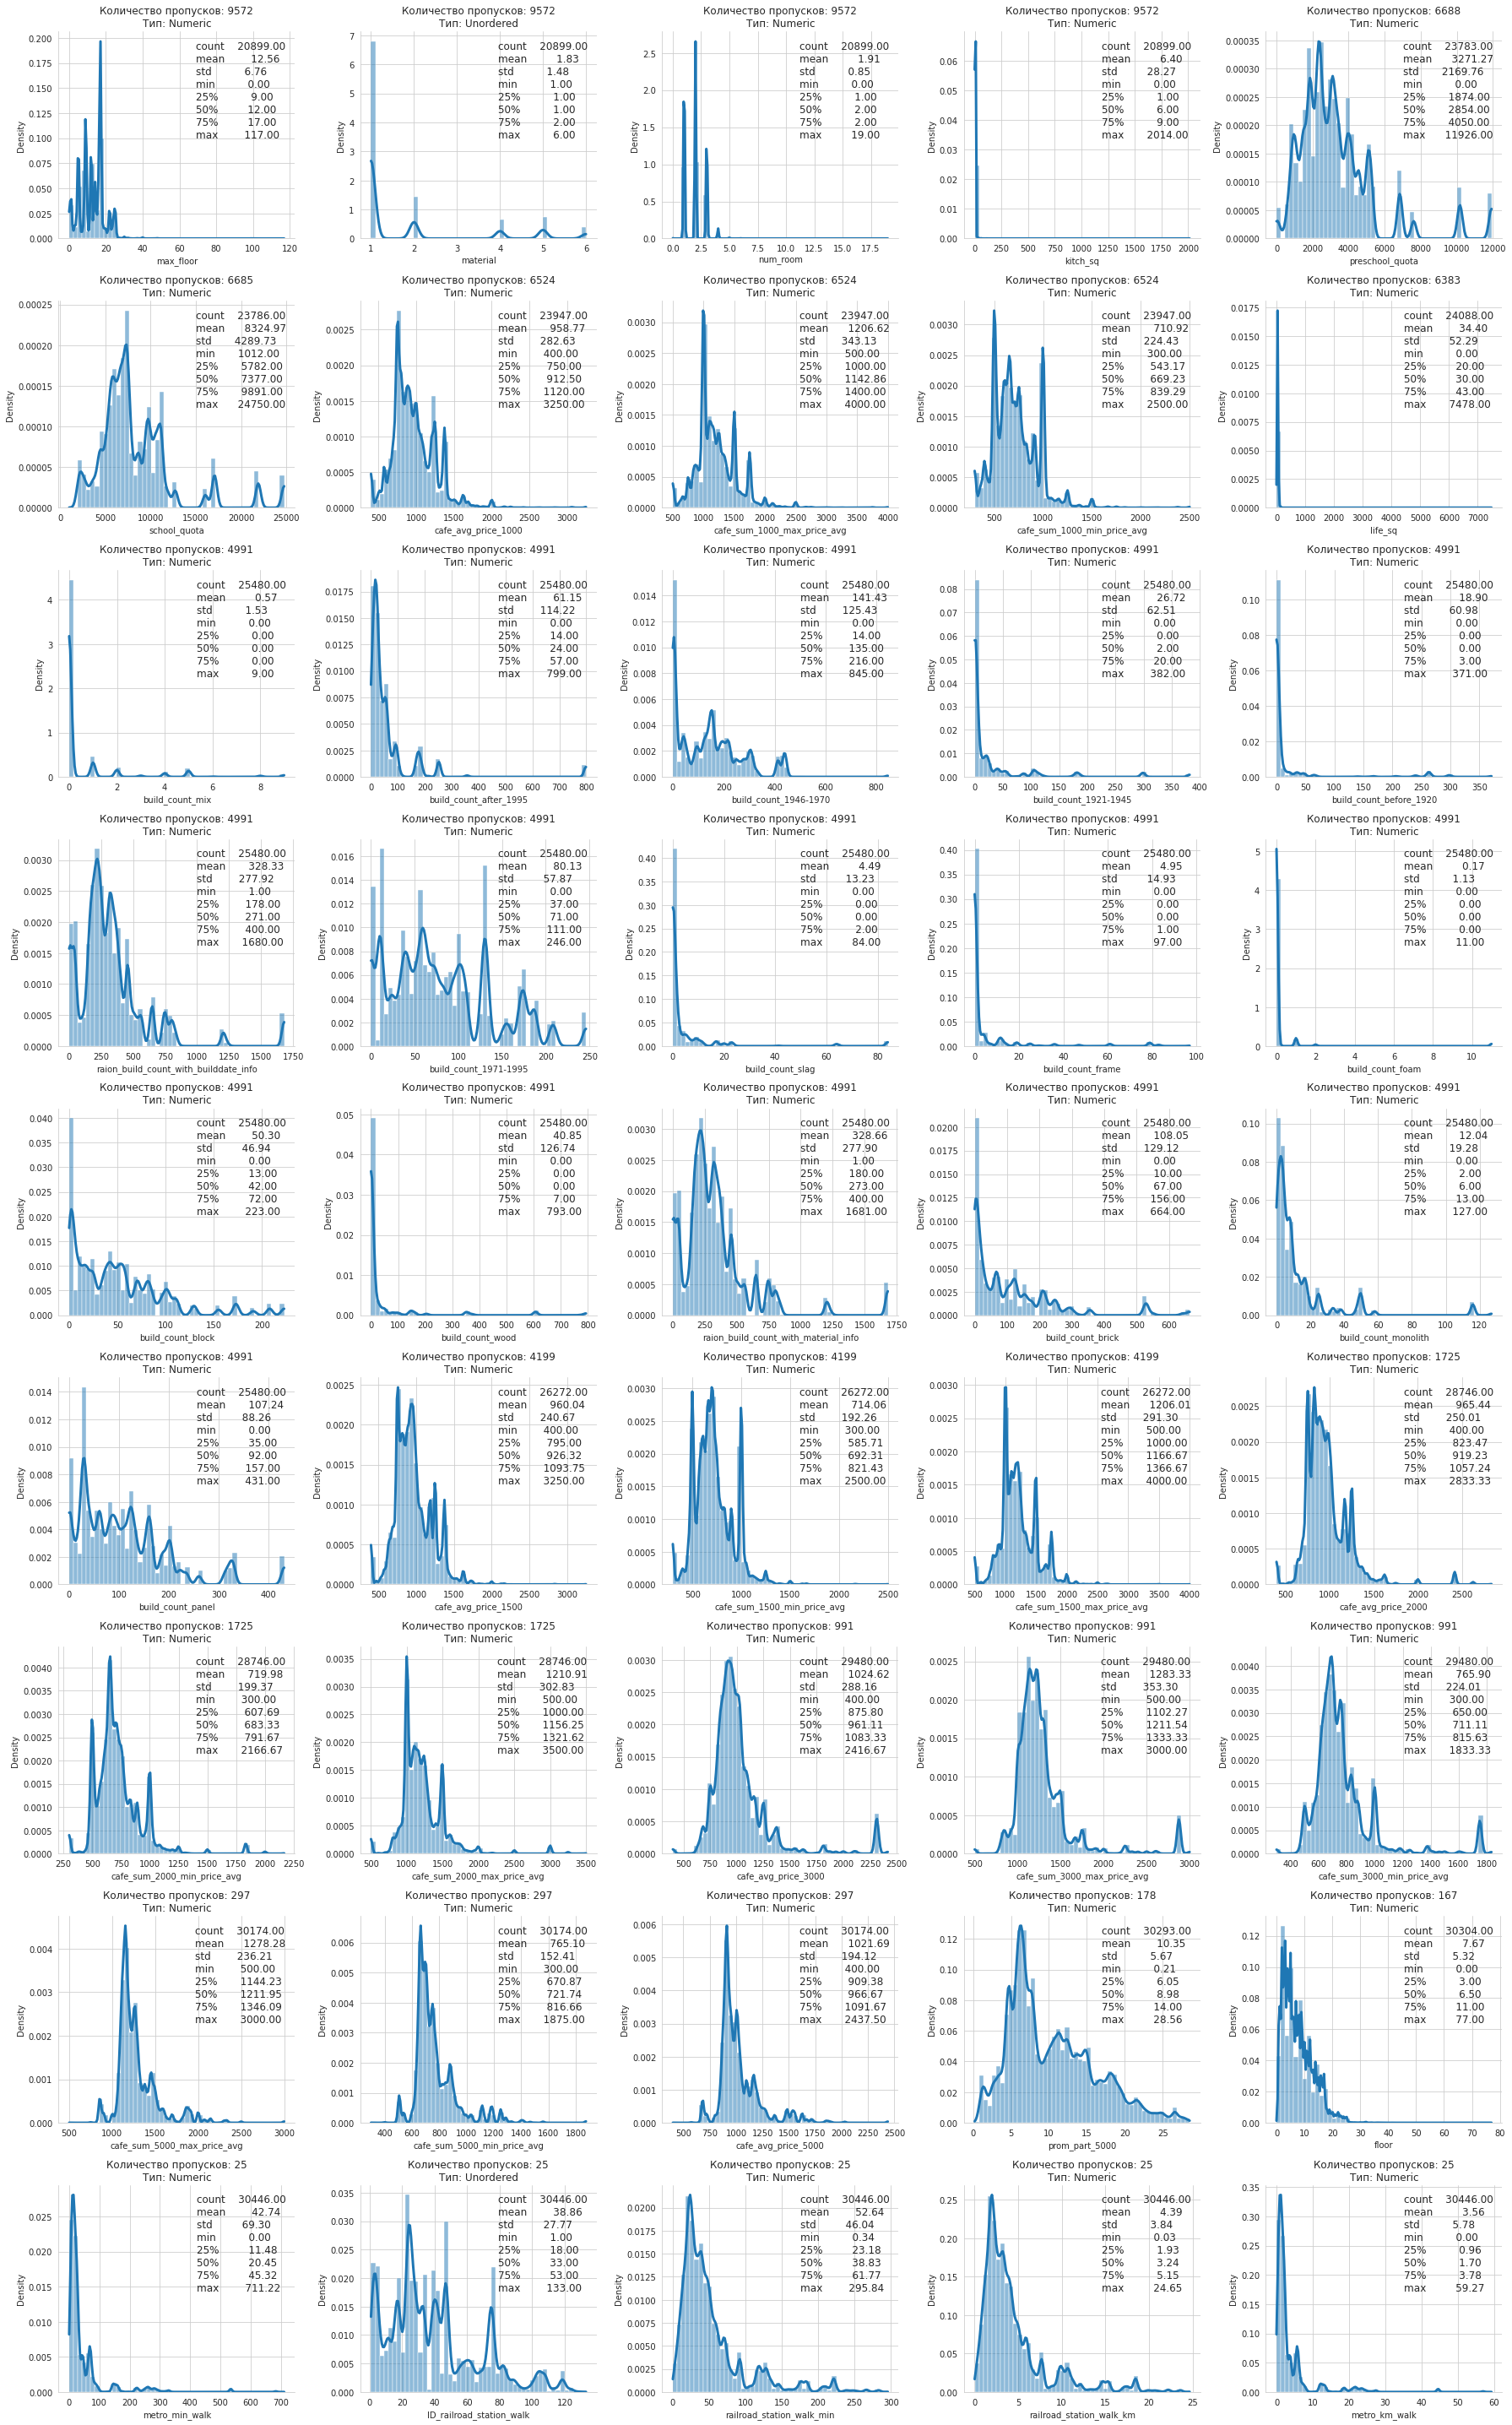

In [63]:
sns.set_style('whitegrid')
sns.set_context(rc = {'lines.linewidth': 3})
fig, ax = plt.subplots(9, 5, figsize=(25, 40), sharey=False)

for i, f in enumerate(features_with_na_2['feature']):
    hst = sns.histplot(
        data=df_train,
        x=f, 
        stat='density', 
        bins=50, 
        legend=True, 
        kde=True,
        kde_kws={'bw_adjust': 0.5}, 
        ax=ax[i//5, i%5])
    hst.set_title(f"Количество пропусков: {int(features_with_na_2[features_with_na_2['feature'] == f]['NA_count'].iloc[0])}\n{features_category(f, binary_features, unordered_cat_teatures, ordered_cat_features, numeric_features)}")

    at = AnchoredText(
        str(round(df_train[f].describe(), 2)).split('Name')[0], 
        prop=dict(size=12), 
        frameon=False, 
        loc='upper right')
    ax[i//5, i%5].add_artist(at)

plt.tight_layout()
sns.despine()

По результату анализа примем:
 ```
- max_floor - проверяем максимум на 17, пропуски заполняем медианой
- num_room - проверяем максимум на  1, пропуски заполняем медианой
- kitch_sq - проверяем максимум
- life_sq - проверяем максимум, пропуски заполняем full_sq

Заполняем нулями:
- cafe_*
- raion_build_count_with_material_info
- kitch_sq

Заполняем медианой:
- prom_part_5000
- floor
- metro_min_walk
- railroad_station_walk_min
- railroad_station_walk_km
- metro_km_walk
- num_room
- max_floor
- build_* - за исключением удаляемых

Заполняем самым частым (категориальные):
- ID_railroad_station_walk
- material

Заполняем средним:
- preschool_quota
- school_quota

Идеи:
- сконструировать признак, отражающий архитектурно-планировочное решение
- кластеризация объектов
```

Заполнение пропусков:

In [64]:
to_zero = ['cafe_avg_price_1000', 'cafe_avg_price_1500', 'cafe_avg_price_2000',
           'cafe_avg_price_3000', 'cafe_avg_price_5000', 'cafe_sum_1000_max_price_avg',
           'cafe_sum_1000_min_price_avg', 'cafe_sum_1500_max_price_avg',
           'cafe_sum_1500_min_price_avg', 'cafe_sum_2000_max_price_avg',
           'cafe_sum_2000_min_price_avg', 'cafe_sum_3000_max_price_avg',
           'cafe_sum_3000_min_price_avg', 'cafe_sum_5000_max_price_avg',
           'cafe_sum_5000_min_price_avg','raion_build_count_with_builddate_info',
           'raion_build_count_with_material_info', 'kitch_sq']

to_median = ['prom_part_5000', 'floor', 'metro_min_walk', 'railroad_station_walk_min',
             'railroad_station_walk_km', 'metro_km_walk', 'num_room', 'max_floor',
             'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995',
             'build_count_after_1995', 'build_count_before_1920', 'build_count_block',
             'build_count_brick', 'build_count_foam', 'build_count_frame',
             'build_count_mix', 'build_count_monolith', 'build_count_panel',
             'build_count_slag', 'build_count_wood']

to_mean= ['preschool_quota', 'school_quota']

to_freq = ['ID_railroad_station_walk', 'material']

In [65]:
df_train[to_zero] = df_train[to_zero].fillna(0)
df_train[to_median] = df_train[to_median].fillna(df_train[to_median].median())
df_train[to_mean] = df_train[to_mean].fillna(df_train[to_mean].mean())
df_train[to_freq] = df_train[to_freq].fillna(df_train[to_freq].mode().iloc[0])
df_train.loc[df_train.life_sq.isna(), 'life_sq'] = df_train.loc[df_train.life_sq.isna(), 'full_sq']

In [66]:
df_train.isna().sum().where(df_train.isna().sum() > 0).dropna()

Series([], dtype: float64)

Проверка аномальных значений:

In [69]:
# + max_floor - проверить макс == 17, заполняем медианой
# + num_room - проверить макс == 1, заполняем медианой
# + kitch_sq - проверить макс
# + life_sq 

np.sort(df_train.max_floor.unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  44.,  45.,
        47.,  48.,  57.,  99., 117.])

In [70]:
df_train[df_train.max_floor.isin([99, 117])]

id   timestamp  ...  market_count_5000  price_doc
20722  20725  2014-07-10  ...                  9   10238400
21734  21737  2014-08-21  ...                  3    8484365
21852  21855  2014-08-25  ...                  0    6670000
25940  25943  2014-12-06  ...                 13    7239838

[4 rows x 292 columns]

In [71]:
df_train.num_room.value_counts()

2.0     17704
1.0      7602
3.0      4675
4.0       418
5.0        40
0.0        14
6.0         9
8.0         3
10.0        2
7.0         1
19.0        1
9.0         1
17.0        1
Name: num_room, dtype: int64

In [72]:
df_train[df_train.num_room > 5].iloc[:, [*range(15),-1]].sort_values(by='full_sq')

id   timestamp  full_sq  ...        area_m  raion_popul  price_doc
11621  11624  2013-10-28       40  ...  2.553630e+07         4001    2630000
26713  26716  2014-12-18       51  ...  6.050065e+06        78616   13150000
19390  19393  2014-06-05       57  ...  1.509487e+07       219609    8000000
17764  17767  2014-04-23       58  ...  1.084231e+07        85219    6000000
29172  29175  2015-04-16       59  ...  1.175477e+07       247469   11000000
24007  24010  2014-10-27       92  ...  1.163805e+07       123280   15400000
10076  10079  2013-08-26      106  ...  1.186638e+08         7538    4980000
28622  28625  2015-03-26      129  ...  7.307411e+06        75377   29700000
18990  18993  2014-05-28      145  ...  7.307411e+06        75377   25500000
21897  21900  2014-08-26      159  ...  8.398461e+06       108171   35000000
13242  13245  2013-12-19      170  ...  8.398461e+06       108171   34800000
18933  18936  2014-05-27      177  ...  8.398461e+06       108171   24267600
29517  29520  2015-05-02      187  ...  1.007156e+07       102726   42300000
29656  29659  2015-05-12      211  ...  1.163805e+07       123280   70000000
15145  15148  2014-02-18      215  ...  7.759254e+06        32071   23000000
28081  28084  2015-02-26      219  ...  2.615514e+07       178264   18000000
28326  28329  2015-03-12      220  ...  1.163805e+07       123280   95122496
16743  16746  2014-03-31      303  ...  6.050065e+06        78616   54212936

[18 rows x 16 columns]

In [73]:
df_train[df_train.kitch_sq > df_train.full_sq].sort_values(by='kitch_sq', ascending=False)

id   timestamp  ...  market_count_5000  price_doc
21415  21418  2014-08-11  ...                  1    3801200
10368  10371  2013-09-10  ...                  1    7281225
28734  28737  2015-03-31  ...                  2    1000000
13117  13120  2013-12-14  ...                 12    3650000
11520  11523  2013-10-24  ...                 11    6300000
28997  29000  2015-04-09  ...                  1    6500000
26850  26853  2014-12-19  ...                 10    2000000
26236  26239  2014-12-11  ...                  0    3281884
9172    9175  2013-07-12  ...                  6    5600000
23216  23219  2014-10-02  ...                  5    5900000
12245  12248  2013-11-18  ...                  3    3600000
8056    8059  2013-05-21  ...                 10    2750000

[12 rows x 292 columns]

In [74]:
df_train[df_train.life_sq > df_train.full_sq].sort_values(by='life_sq', ascending=False)

id   timestamp  ...  market_count_5000  price_doc
13546  13549  2013-12-30  ...                  1    7705000
9646    9649  2013-08-06  ...                  5   12031350
9256    9259  2013-07-17  ...                  7   13750000
26342  26345  2014-12-12  ...                  4   12900000
4385    4388  2012-10-25  ...                 14   11918400
21080  21083  2014-07-24  ...                  2    7200000
9237    9240  2013-07-16  ...                  5    5600000
1084    1085  2012-02-06  ...                  4    6200000
13629  13632  2014-01-10  ...                  0    4900000
7208    7211  2013-04-10  ...                 10    6400000
6336    6339  2013-03-06  ...                  6    5400000
1863    1866  2012-04-11  ...                  7    5900000
13797  13800  2014-01-16  ...                  1    3550000
6531    6534  2013-03-15  ...                 11   13801229
16116  16119  2014-03-17  ...                  0    8762000
24428  24431  2014-11-07  ...                  1    7419500
6993    6996  2013-04-03  ...                  1    6290256
14799  14802  2014-02-10  ...                  1    7488400
24296  24299  2014-11-05  ...                  0    8167508
26363  26366  2014-12-12  ...                  5   14430018
16284  16287  2014-03-20  ...                  2    3759912
26264  26267  2014-12-11  ...                  1    5983900
12569  12572  2013-11-27  ...                  5    9897007
11784  11787  2013-11-02  ...                  1   15000000
11711  11714  2013-10-31  ...                  7    2000000
29302  29305  2015-04-22  ...                  7   11000000
22804  22807  2014-09-23  ...                 13    8586239
9482    9485  2013-07-27  ...                  4    3000000
16067  16070  2014-03-15  ...                  0    3661580
22412  22415  2014-09-11  ...                  9   14923206
20672  20675  2014-07-08  ...                  4    3707340
1188    1189  2012-02-14  ...                  9    6300000
11332  11335  2013-10-18  ...                  1    3357774
2009    2012  2012-04-25  ...                  5    5770000
22611  22614  2014-09-17  ...                 13    6555970
8101    8104  2013-05-23  ...                  1    3622465
1822    1825  2012-04-09  ...                  9    5200000

[37 rows x 292 columns]

In [75]:
df_train[df_train.full_sq < 10].sort_values(by='full_sq', ascending=False)

id   timestamp  ...  market_count_5000  price_doc
1188    1189  2012-02-14  ...                  9    6300000
6112    6115  2013-02-22  ...                  1    5177040
2009    2012  2012-04-25  ...                  5    5770000
23228  23231  2014-10-03  ...                 15   13452318
26925  26928  2014-12-20  ...                  0    3793778
26582  26585  2014-12-16  ...                 10   10145891
26386  26389  2014-12-13  ...                  3    5510645
26363  26366  2014-12-12  ...                  5   14430018
26264  26267  2014-12-11  ...                  1    5983900
25887  25890  2014-12-05  ...                  5   16160462
25569  25572  2014-12-01  ...                  0    4838066
24892  24895  2014-11-18  ...                  5   17035200
24627  24630  2014-11-12  ...                  1    5000550
23726  23729  2014-10-20  ...                  1    4819000
23573  23576  2014-10-15  ...                 12   11731927
23048  23051  2014-09-29  ...                  4   27259184
22871  22874  2014-09-24  ...                  1    4740000
22795  22798  2014-09-23  ...                  1    5591788
22722  22725  2014-09-20  ...                  1    4740000
22412  22415  2014-09-11  ...                  9   14923206
22171  22174  2014-09-03  ...                  0    6256186
18600  18603  2014-05-19  ...                 13    6675730
17194  17197  2014-04-09  ...                  9   13066000
16738  16741  2014-03-31  ...                  1    7820575
16289  16292  2014-03-20  ...                  1    4457400
11332  11335  2013-10-18  ...                  1    3357774
27154  27157  2014-12-26  ...                 10   15318960
24296  24299  2014-11-05  ...                  0    8167508
17932  17935  2014-04-28  ...                  1    4425000

[29 rows x 292 columns]

In [76]:
df_train.loc[df_train.max_floor.isin([99, 117]), 'max_floor'] = df_train.loc[df_train.max_floor.isin([99, 117]), 'floor']

In [77]:
df_train.loc[[11621, 26713], 'num_room'] = df_train.num_room.median()

In [78]:
df_train.loc[df_train.kitch_sq > df_train.full_sq, 'kitch_sq'] = 0
df_train.loc[13117, 'build_year'] = 1970

In [79]:
df_train.loc[df_train.full_sq < 10, 'full_sq'] = df_train.loc[df_train.full_sq < 10, 'life_sq']
df_train.loc[df_train.life_sq > df_train.full_sq, 'life_sq'] = df_train.loc[df_train.life_sq > df_train.full_sq, 'full_sq']

Проверим распределения после выполненных действий:

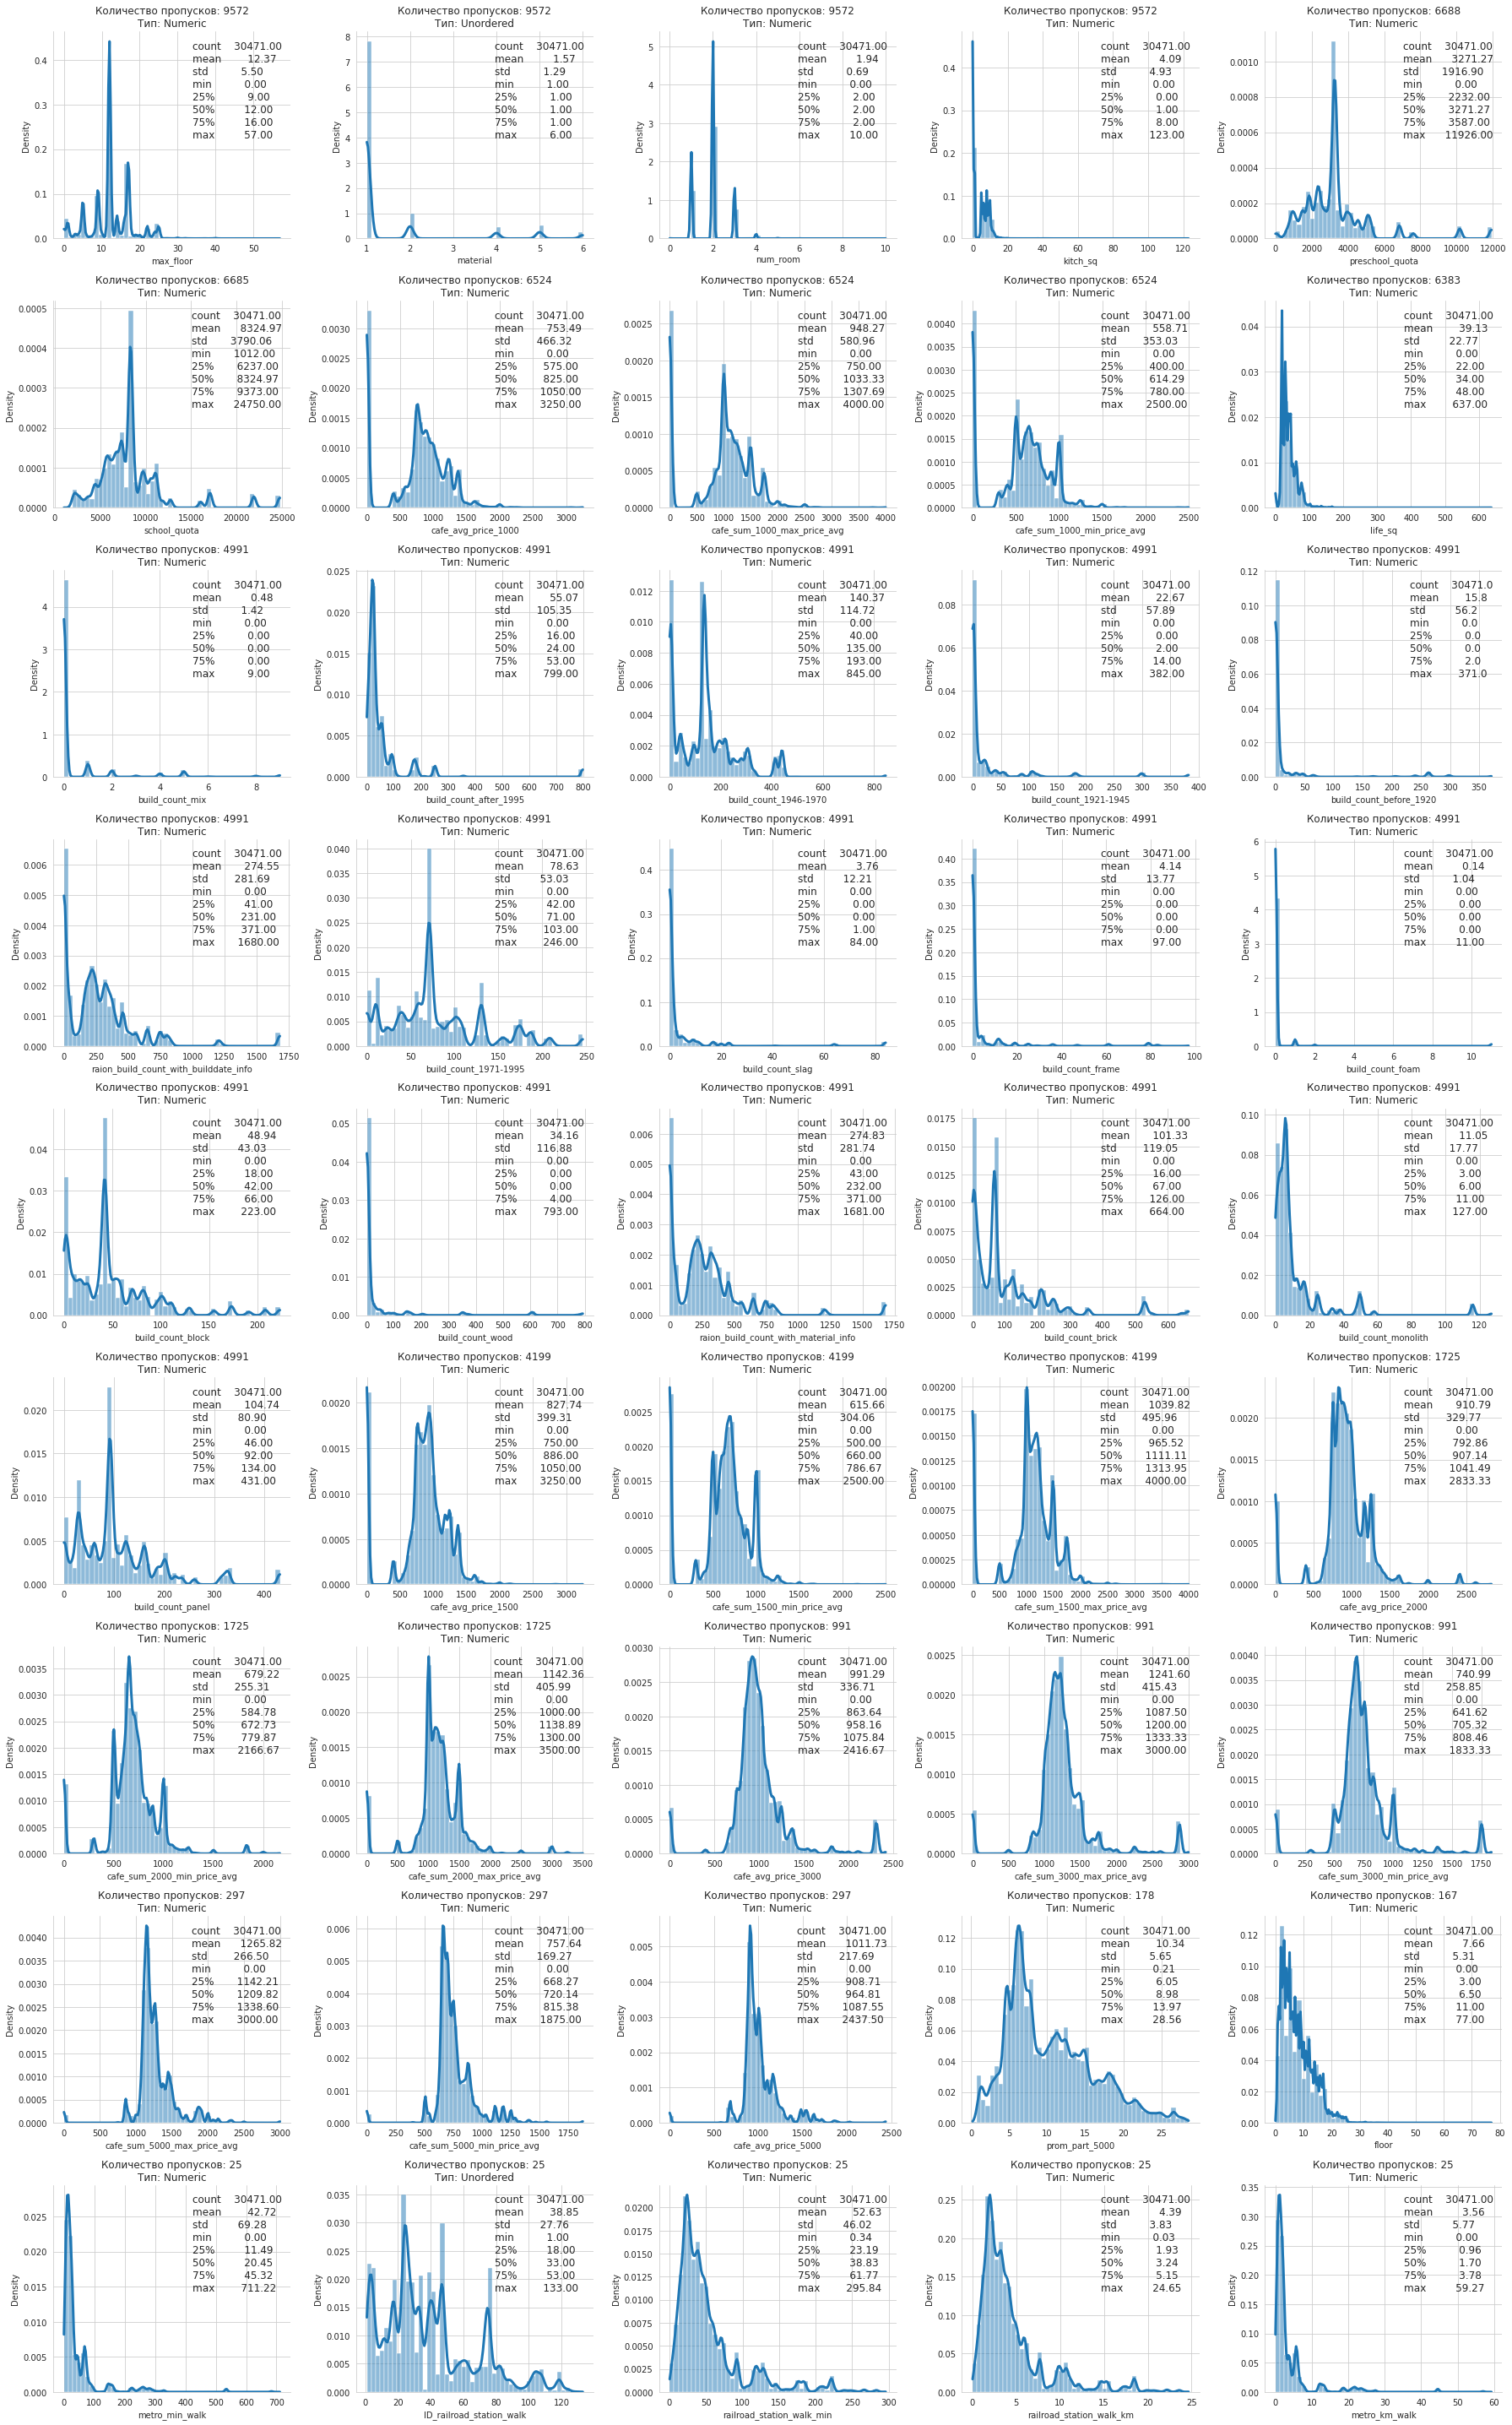

In [80]:
sns.set_style('whitegrid')
sns.set_context(rc = {'lines.linewidth': 3})
fig, ax = plt.subplots(9, 5, figsize=(25, 40), sharey=False)

for i, f in enumerate(features_with_na_2['feature']):
    hst = sns.histplot(
        data=df_train,
        x=f, 
        stat='density', 
        bins=50, 
        legend=True, 
        kde=True,
        kde_kws={'bw_adjust': 0.5}, 
        ax=ax[i//5, i%5])
    hst.set_title(f"Количество пропусков: {int(features_with_na_2[features_with_na_2['feature'] == f]['NA_count'].iloc[0])}\n{features_category(f, binary_features, unordered_cat_teatures, ordered_cat_features, numeric_features)}")

    at = AnchoredText(
        str(round(df_train[f].describe(), 2)).split('Name')[0], 
        prop=dict(size=12), 
        frameon=False, 
        loc='upper right')
    ax[i//5, i%5].add_artist(at)

plt.tight_layout()
sns.despine()

Аномалий не обнаружено

# **4. Преобразование типов данных**

Типы данных, исходя из описания датасета:

In [81]:
features_types = {
    'full_sq': float,
    'life_sq': float,
    'floor': int,
    'max_floor': int,
    'material': int,
    'build_year': int,
    'num_room': int,
    'kitch_sq': float,
    'state': 'Int64',
    'area_m': float,
    'raion_popul': int,
    'green_zone_part': float,
    'indust_part': float,
    'children_preschool': int,
    'preschool_quota': int,
    'preschool_education_centers_raion': int,
    'children_school': int,
    'school_quota': int,
    'school_education_centers_raion': int,
    'school_education_centers_top_20_raion': int,
    'hospital_beds_raion': int,
    'healthcare_centers_raion':int,
    'university_top_20_raion': int,
    'sport_objects_raion': int,
    'additional_education_raion': int,
    'culture_objects_top_25_raion': int,
    'shopping_centers_raion': int,
    'office_raion': int,
    'full_all': int,
    'male_f': int,
    'female_f': int,
    'young_all': int,
    'young_male': int,
    'young_female': int,
    'work_all': int,
    'work_male': int,
    'work_female': int,
    'ekder_all': int,
    'ekder_male': int,
    'ekder_female': int,
    '0_6_all': int,
    '0_6_male': int,
    '0_6_female': int,
    '7_14_all': int,
    '7_14_male': int,
    '7_14_female': int,
    '0_17_all': int,
    '0_17_male': int,
    '0_17_female': int,
    '16_29_all': int,
    '16_29_male': int,
    '16_29_female': int,
    '0_13_all': int,
    '0_13_male': int,
    '0_13_female': int,
    'raion_build_count_with_material_info': int,
    'build_count_block':int,
    'build_count_wood': int,
    'build_count_frame': int,
    'build_count_brick': int,
    'build_count_monolith': int,
    'build_count_panel': int,
    'build_count_foam': int,
    'build_count_slag': int,
    'build_count_mix': int,
    'raion_build_count_with_builddate_info': int,
    'build_count_before_1920': int,
    'build_count_1921-1945': int,
    'build_count_1946-1970': int,
    'build_count_1971-1995': int,
    'build_count_after_1995': int,
    'ID_metro': int,
    'metro_min_avto': float,
    'metro_km_avto': float,
    'metro_min_walk': float,
    'metro_km_walk': float,
    'kindergarten_km': float,
    'school_km': float,
    'park_km': float,
    'green_zone_km': float,
    'industrial_km': float,
    'water_treatment_km': float,
    'cemetery_km': float,
    'incineration_km': float,
    'railroad_station_walk_km': float,
    'railroad_station_walk_min': float,
    'ID_railroad_station_walk': int,
    'railroad_station_avto_km': float,
    'railroad_station_avto_min': float,
    'ID_railroad_station_avto': int,
    'public_transport_station_km': float,
    'public_transport_station_min_walk': float,
    'water_km': float,
    'mkad_km': float,
    'ttk_km': float,
    'sadovoe_km': float,
    'bulvar_ring_km': float,
    'kremlin_km': float,
    'big_road1_km': float,
    'ID_big_road1': int,
    'big_road2_km': float,
    'ID_big_road2': int,
    'railroad_km': float,
    'zd_vokzaly_avto_km': float,
    'ID_railroad_terminal': int,
    'bus_terminal_avto_km': float,
    'ID_bus_terminal': int,
    'oil_chemistry_km': float,
    'nuclear_reactor_km': float,
    'radiation_km': float,
    'power_transmission_line_km': float,
    'thermal_power_plant_km': float,
    'ts_km': float,
    'big_market_km': float,
    'market_shop_km': float,
    'fitness_km': float,
    'swim_pool_km': float,
    'ice_rink_km': float,
    'stadium_km': float,
    'basketball_km': float,
    'hospice_morgue_km': float,
    'detention_facility_km': float,
    'public_healthcare_km': float,
    'university_km': float,
    'workplaces_km': float,
    'shopping_centers_km': float,
    'office_km': float,
    'additional_education_km': float,
    'preschool_km': float,
    'big_church_km': float,
    'church_synagogue_km': float,
    'mosque_km': float,
    'theater_km': float,
    'museum_km': float,
    'exhibition_km': float,
    'catering_km':float,
    'green_part_500': float,
    'prom_part_500': float,
    'office_count_500':int,
    'office_sqm_500': int,
    'trc_count_500':int,
    'trc_sqm_500': float,
    'cafe_count_500': int,
    'cafe_sum_500_min_price_avg': float,
    'cafe_sum_500_max_price_avg': float,
    'cafe_avg_price_500': float,
    'cafe_count_500_na_price': int,
    'cafe_count_500_price_500': int,
    'cafe_count_500_price_1000': int,
    'cafe_count_500_price_1500': int,
    'cafe_count_500_price_2500':int,
    'cafe_count_500_price_4000': int,
    'cafe_count_500_price_high': int,
    'big_church_count_500': int,
    'church_count_500': int,
    'mosque_count_500': int,
    'leisure_count_500': int,
    'sport_count_500': int,
    'market_count_500': int,
    'green_part_1000': float,
    'prom_part_1000': float,
    'office_count_1000': int,
    'office_sqm_1000': float,
    'trc_count_1000': int,
    'trc_sqm_1000': float,
    'cafe_count_1000':int,
    'cafe_sum_1000_min_price_avg': float,
    'cafe_sum_1000_max_price_avg': float,
    'cafe_avg_price_1000': float,
    'cafe_count_1000_na_price': int,
    'cafe_count_1000_price_500': int,
    'cafe_count_1000_price_1000': int,
    'cafe_count_1000_price_1500': int,
    'cafe_count_1000_price_2500': int,
    'cafe_count_1000_price_4000': int,
    'cafe_count_1000_price_high': int,
    'big_church_count_1000': int,
    'church_count_1000': int,
    'mosque_count_1000': int,
    'leisure_count_1000': int,
    'sport_count_1000': int,
    'market_count_1000': int,
    'green_part_1500': float,
    'prom_part_1500': float,
    'office_count_1500': int,
    'office_sqm_1500': float,
    'trc_count_1500': int,
    'trc_sqm_1500': float,
    'cafe_count_1500': int,
    'cafe_sum_1500_min_price_avg': float,
    'cafe_sum_1500_max_price_avg': float,
    'cafe_avg_price_1500': float,
    'cafe_count_1500_na_price': int,
    'cafe_count_1500_price_500': int,
    'cafe_count_1500_price_1000': int,
    'cafe_count_1500_price_1500': int,
    'cafe_count_1500_price_2500': int,
    'cafe_count_1500_price_4000': int,
    'cafe_count_1500_price_high': int,
    'big_church_count_1500': int,
    'church_count_1500': int,
    'mosque_count_1500': int,
    'leisure_count_1500': int,
    'sport_count_1500': int,
    'market_count_1500': int,
    'green_part_2000': float,
    'prom_part_2000': float,
    'office_count_2000': int,
    'office_sqm_2000': float,
    'trc_count_2000': int,
    'trc_sqm_2000': float,
    'cafe_count_2000': int,
    'cafe_sum_2000_min_price_avg': float,
    'cafe_sum_2000_max_price_avg': float,
    'cafe_avg_price_2000': float,
    'cafe_count_2000_na_price':int,
    'cafe_count_2000_price_500': int,
    'cafe_count_2000_price_1000': int,
    'cafe_count_2000_price_1500': int,
    'cafe_count_2000_price_2500': int,
    'cafe_count_2000_price_4000': int,
    'cafe_count_2000_price_high': int,
    'big_church_count_2000': int,
    'church_count_2000': int,
    'mosque_count_2000':int,
    'leisure_count_2000': int,
    'sport_count_2000': int,
    'market_count_2000':int,
    'green_part_3000': float,
    'prom_part_3000': float,
    'office_count_3000': int,
    'office_sqm_3000': float,
    'trc_count_3000': int,
    'trc_sqm_3000': float,
    'cafe_count_3000': int,
    'cafe_sum_3000_min_price_avg': float,
    'cafe_sum_3000_max_price_avg': float,
    'cafe_avg_price_3000': float,
    'cafe_count_3000_na_price': int,
    'cafe_count_3000_price_500': int,
    'cafe_count_3000_price_1000': int,
    'cafe_count_3000_price_1500': int,
    'cafe_count_3000_price_2500': int,
    'cafe_count_3000_price_4000': int,
    'cafe_count_3000_price_high': int,
    'big_church_count_3000': int,
    'church_count_3000': int,
    'mosque_count_3000': int,
    'leisure_count_3000': int,
    'sport_count_3000': int,
    'market_count_3000': int,
    'green_part_5000': float,
    'prom_part_5000': float,
    'office_count_5000': int,
    'office_sqm_5000': float,
    'trc_count_5000': int,
    'trc_sqm_5000': float,
    'cafe_count_5000': int,
    'cafe_sum_5000_min_price_avg': float,
    'cafe_sum_5000_max_price_avg': float,
    'cafe_avg_price_5000': float,
    'cafe_count_5000_na_price': int,
    'cafe_count_5000_price_500': int,
    'cafe_count_5000_price_1000': int,
    'cafe_count_5000_price_1500': int,
    'cafe_count_5000_price_2500': int,
    'cafe_count_5000_price_4000': int,
    'cafe_count_5000_price_high': int,
    'big_church_count_5000': int,
    'church_count_5000': int,
    'mosque_count_5000': int,
    'leisure_count_5000': int,
    'sport_count_5000': int,
    'market_count_5000': int,
    'price_doc': float
}

```
binary_features
ordered_cat_features
unordered_cat_teatures
numeric_features
```

Преобразуем типы признаков:

In [82]:
def dataset_preparation(data, label_encoding_list, unordered_features_list, ordered_features_dict, types_dict):

    data['year_trans'] = data['timestamp'].apply(lambda k: k.split('-')[0]).astype(int)
    data['month_trans'] = data['timestamp'].apply(lambda k: k.split('-')[1]).astype(int)
    data['day_trans'] = data['timestamp'].apply(lambda k: k.split('-')[2]).astype(int)
    
    data = data.drop(columns=['id', 'timestamp'])

    for f, t in types_dict.items():
        data[f] = data[f].astype(t)

    le = LabelEncoder()
    for f in label_encoding_list:
        data[f] = le.fit_transform(data[f]).astype(int)

    for f in unordered_features_list:
        data[f] = data[f].astype('category')
        
    for f, levels in ordered_features_dict.items():
        data[f] = data[f].astype(CategoricalDtype(levels, ordered=True))

    return data

In [83]:
df_train_typified = dataset_preparation(
    df_train,
    binary_features,
    unordered_cat_teatures,
    ordered_cat_features,
    features_types)

In [84]:
df_train_typified.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 293 columns):
 #   Column                                 Dtype   
---  ------                                 -----   
 0   full_sq                                float64 
 1   life_sq                                float64 
 2   floor                                  int64   
 3   max_floor                              int64   
 4   material                               category
 5   build_year                             int64   
 6   num_room                               int64   
 7   kitch_sq                               float64 
 8   state                                  category
 9   product_type                           int64   
 10  sub_area                               category
 11  area_m                                 float64 
 12  raion_popul                            int64   
 13  green_zone_part                        float64 
 14  indust_part                          

Убедимся, что пропусков больше нет:

In [85]:
df_train_typified.isna().any().any()

False

# **5. Анализ признаков**

## **Целевая переменная**

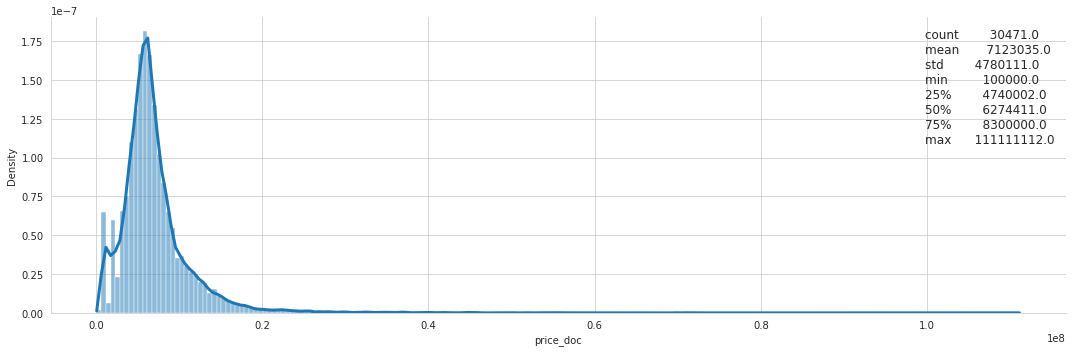

In [86]:
plot_histwithkde_scatter_to_target(
    data=df_train_typified,
    feature=target,
    target=target,
    loc='upper right',
    figsize=(15,5),
    bins=200
)

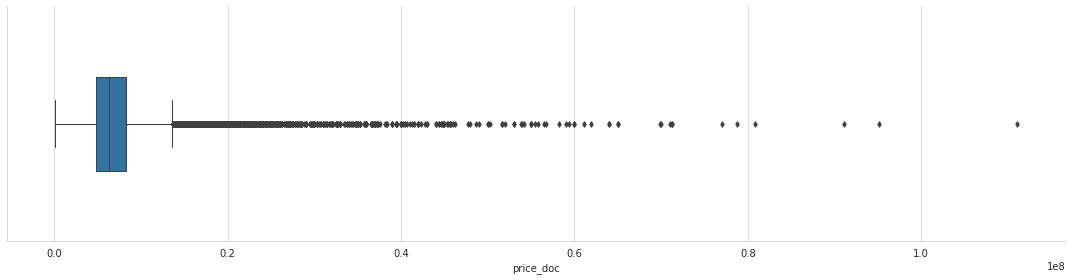

In [87]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
sns.boxplot(df_train_typified[target], width=0.4, linewidth=1, fliersize=4, ax=ax)
sns.despine()
plt.tight_layout()
plt.show()

Видны выбросы сверху, рассмотрим эти объекты в пространстве основных признаков:

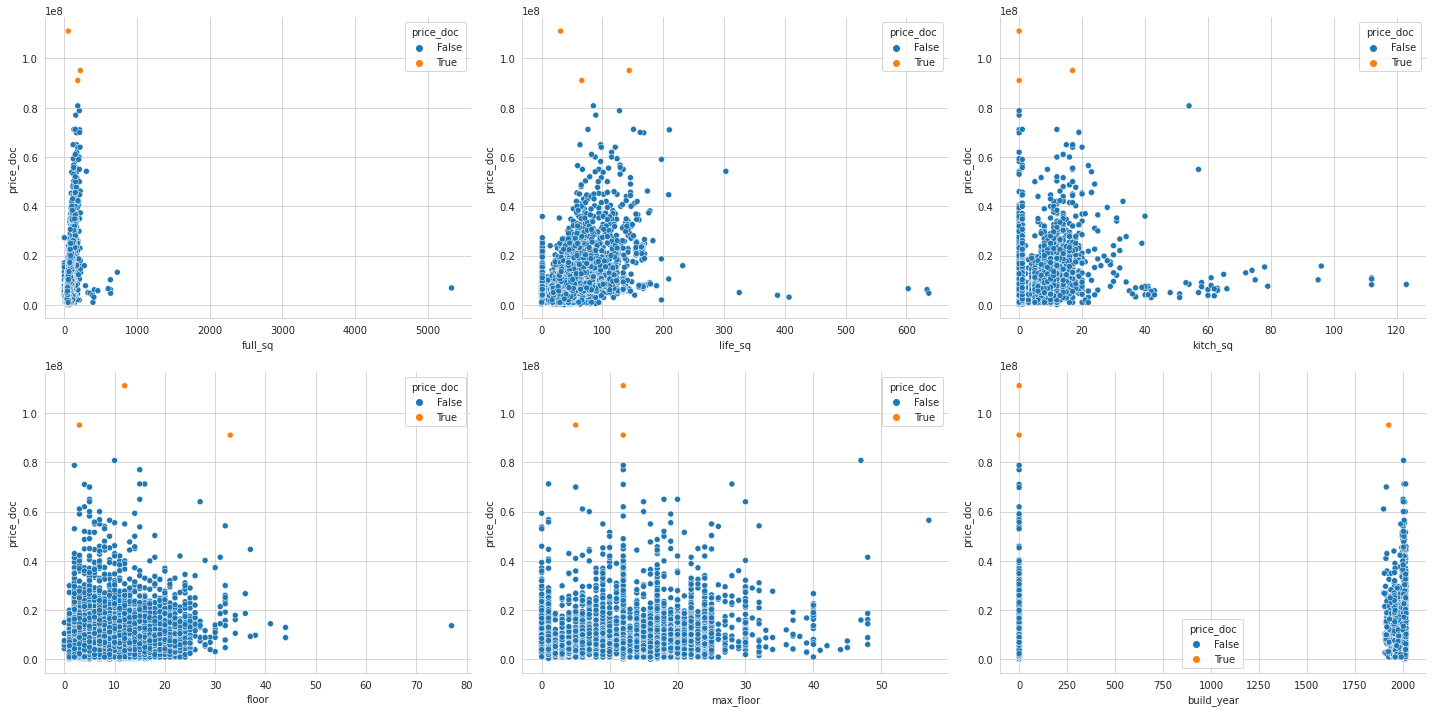

In [88]:
hue = masked_outlier(df_train_typified, 16, target)

plot_scatters_to_target(
    data=df_train_typified,
    features=['full_sq', 'life_sq', 'kitch_sq', 'floor', 'max_floor', 'build_year'],
    target=target,
    hue=hue,
    nrows=2,
    ncols=3,
    figsize=(20,10)
)

In [89]:
hue.value_counts()

False    30468
True         3
Name: price_doc, dtype: int64

Их три, удалим эти объекты:

In [90]:
df_train_typified = remove_outlier(df_train_typified, target, 16)

Для устранения смещения распределения целевой переменной прологарифмируем ее:

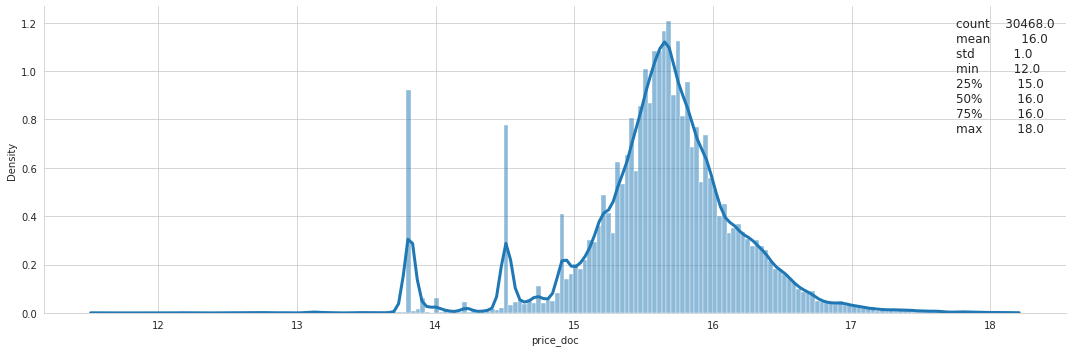

In [91]:
df_train_typified_outlier = df_train_typified.copy()
df_train_typified_outlier[target] = np.log1p(df_train_typified_outlier[target])
plot_histwithkde_scatter_to_target(
    data=df_train_typified_outlier,
    feature=target,
    target=target,
    loc='upper right',
    figsize=(15,5),
    bins=200
)

Видны выбросы снизу:

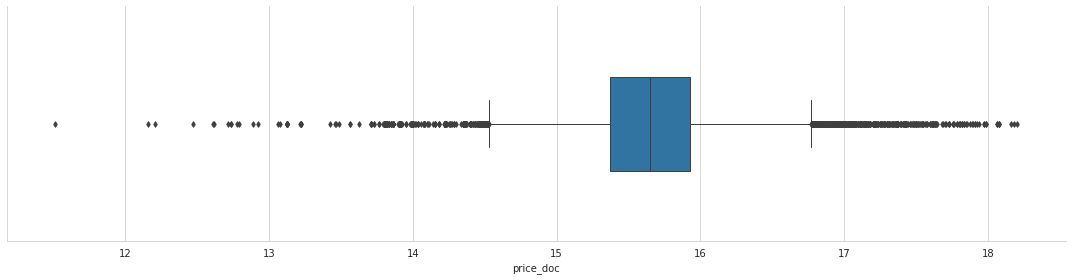

In [92]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
sns.boxplot(df_train_typified_outlier[target], width=0.4, linewidth=1, fliersize=4, ax=ax)
sns.despine()
plt.tight_layout()
plt.show()

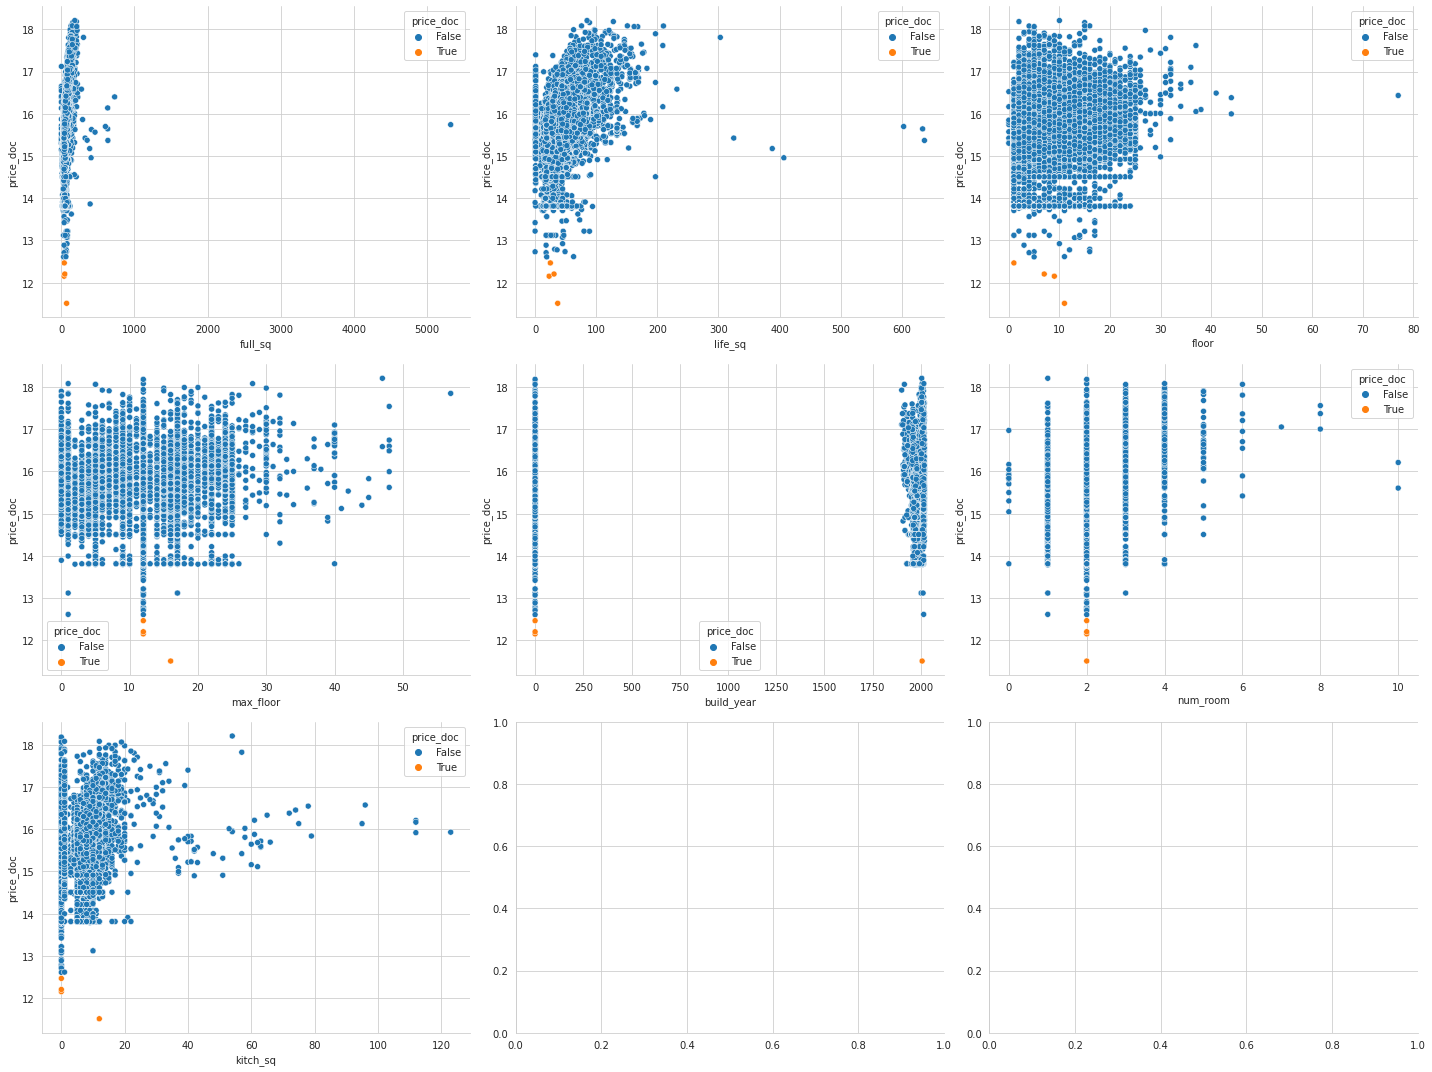

In [93]:
hue = masked_outlier(df_train_typified_outlier, 5, target)

plot_scatters_to_target(
    data=df_train_typified_outlier,
    features=['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq'],
    target=target,
    hue=hue,
    nrows=3,
    ncols=3,
    figsize=(20,15)
)

In [94]:
hue.value_counts()

False    30464
True         4
Name: price_doc, dtype: int64

Их четыре. удалим эти объекты:

In [95]:
df_train_typified_outlier = remove_outlier(df_train_typified_outlier, target, 5)

## **Корреляция признаков**

Рассмотрим различные виды корреляций:

In [96]:
corr_matrix_pearson = df_train_typified_outlier.corr(method='pearson')
corr_matrix_kendall = df_train_typified_outlier.corr(method='kendall')
corr_matrix_spearman = df_train_typified_outlier.corr(method='spearman')
phik_overview = df_train_typified_outlier.phik_matrix()

interval columns not set, guessing: ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'product_type', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female

Посмотрим сколько коррелирующих признаков определены каждым видом:

In [97]:
_, drops_p = remove_hicorr_features(df_train_typified_outlier, corr_matrix_pearson.drop(columns=[target], index=[target]), 0.6, target)
len(drops_p)

228

In [98]:
_, drops_k = remove_hicorr_features(df_train_typified_outlier, corr_matrix_kendall.drop(columns=[target], index=[target]), 0.6, target)
len(drops_k)

180

In [99]:
_, drops_s = remove_hicorr_features(df_train_typified_outlier, corr_matrix_spearman.drop(columns=[target], index=[target]), 0.6, target)
len(drops_s)

213

In [100]:
_, drops_phik = remove_hicorr_features(df_train_typified_outlier, phik_overview.drop(columns=[target], index=[target]), 0.6, target)
len(drops_phik)

282

Метод фи-к оказался самым "жадным", Кендал самым бережливым

Применим бережливую стратегию, удалим только общие высоко коррелирующие признаки:

In [101]:
hicorr_cols = set.intersection(*[set(drops_p), set(drops_k), set(drops_s), set(drops_phik)])
hicorr_cols = sorted(list(hicorr_cols))
len(hicorr_cols)

175

In [102]:
df_train_typified_outlier = df_train_typified_outlier.drop(columns=hicorr_cols)

Рассмотрим графически корреляции оставшихся признаков:

In [103]:
corr_matrix_pearson = df_train_typified_outlier.corr(method='pearson')
corr_matrix_kendall = df_train_typified_outlier.corr(method='kendall')
corr_matrix_spearman = df_train_typified_outlier.corr(method='spearman')
phik_overview = df_train_typified_outlier.phik_matrix()

interval columns not set, guessing: ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'product_type', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_quota', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25', 'shopping_centers_raion', 'office_raion', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'full_all', 'build_count_block', 'build_count_wood', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'metro_min_avto', 'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incin

In [104]:
plot_corr_matrix(corr_matrix_pearson, (70,70), fontsize=8)

Output hidden; open in https://colab.research.google.com to view.

In [105]:
plot_corr_matrix(corr_matrix_kendall, (70,70), fontsize=8)

Output hidden; open in https://colab.research.google.com to view.

In [106]:
plot_corr_matrix(corr_matrix_spearman, (70,70),fontsize=8)

Output hidden; open in https://colab.research.google.com to view.

In [107]:
plot_corr_matrix(phik_overview, (70,70), fontsize=8, cmap=sns.light_palette('FireBrick', as_cmap=True))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cmpf = corr_matrix_pearson[target].sort_values(ascending=False).to_frame().reset_index().rename(columns={'index': 'feature', target: 'corr_value_p'})

In [ ]:
cmkf = corr_matrix_kendall[target].sort_values(ascending=False).to_frame().reset_index().rename(columns={'index': 'feature', target: 'corr_value_k'})

In [ ]:
cmsf = corr_matrix_spearman[target].sort_values(ascending=False).to_frame().reset_index().rename(columns={'index': 'feature', target: 'corr_value_s'})

In [ ]:
cmphik = phik_overview[target].sort_values(ascending=False).to_frame().reset_index().rename(columns={'index': 'feature', target: 'corr_value_phik'})

In [112]:
df_corr = cmpf.merge(cmkf, how='left', on='feature').merge(cmsf, how='left', on='feature').merge(cmphik, how='outer', on='feature')
cmp = corr_matrix_pearson[target].sort_values(ascending=False).to_frame().drop(index=target).reset_index().rename(columns={'index': 'feature', target: 'corr_value'})
cmk = corr_matrix_kendall[target].sort_values(ascending=False).to_frame().drop(index=target).reset_index().rename(columns={'index': 'feature', target: 'corr_value'})
cms = corr_matrix_spearman[target].sort_values(ascending=False).to_frame().drop(index=target).reset_index().rename(columns={'index': 'feature', target: 'corr_value'})
cmphik = phik_overview[target].sort_values(ascending=False).to_frame().drop(index=target).reset_index().rename(columns={'index': 'feature', target: 'corr_value'})
cmp['corr_method'] = 'pearson'
cmk['corr_method'] = 'kendall'
cms['corr_method'] = 'spearman'
cmphik['corr_method'] = 'phik'
df_corr2 = pd.concat([cmp, cmk, cms, cmphik], axis=0).reset_index(drop=True).sort_values(by='corr_value',ascending=False)
df_corr2

feature  corr_value corr_method
318                  ID_metro    0.626233        phik
319                  sub_area    0.614304        phik
320  ID_railroad_station_avto    0.554311        phik
321  ID_railroad_station_walk    0.542113        phik
212                   full_sq    0.522025    spearman
..                        ...         ...         ...
313            metro_min_avto   -0.294405    spearman
314             workplaces_km   -0.296299    spearman
315              swim_pool_km   -0.302449    spearman
316        nuclear_reactor_km   -0.311972    spearman
317                    ttk_km   -0.327924    spearman

[435 rows x 3 columns]

Посмотрим на признаки с нулевой, высокой и низкой корреляцией:

Остаток высоко коррелированных признаков определяется метод фи-к:

In [114]:
df_corr2[df_corr2.corr_value >= 0.5]

feature  corr_value corr_method
318                  ID_metro    0.626233        phik
319                  sub_area    0.614304        phik
320  ID_railroad_station_avto    0.554311        phik
321  ID_railroad_station_walk    0.542113        phik
212                   full_sq    0.522025    spearman
322                  num_room    0.517803        phik

А обратно коррелирующих - Спирменом:

In [115]:
df_corr2[df_corr2.corr_value < 0].tail(10)

feature  corr_value corr_method
308  detention_facility_km   -0.264597    spearman
309            catering_km   -0.273632    spearman
310              office_km   -0.286698    spearman
311   public_healthcare_km   -0.290994    spearman
312          big_church_km   -0.294379    spearman
313         metro_min_avto   -0.294405    spearman
314          workplaces_km   -0.296299    spearman
315           swim_pool_km   -0.302449    spearman
316     nuclear_reactor_km   -0.311972    spearman
317                 ttk_km   -0.327924    spearman

Интересно, что метод фи-к определил корреляцию признакнака ```full_sq``` как нулевую, в отличие от Спирмена. Действительно, визульная видна значительная корреляция, возможно это связано именно с выбросами в признаке:

In [113]:
df_corr2[df_corr2.corr_value == 0]

feature  corr_value corr_method
434  full_sq         0.0        phik

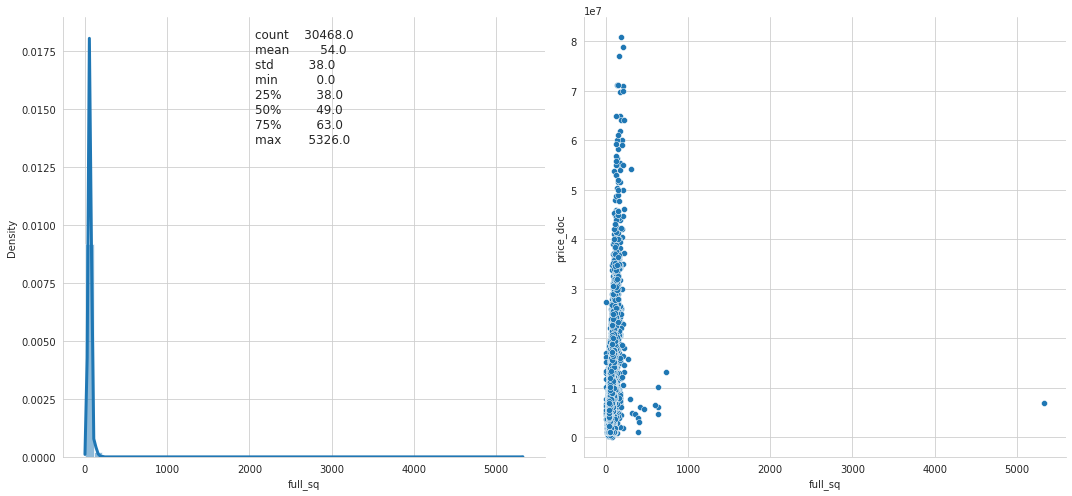

In [116]:
plot_histwithkde_scatter_to_target(df_train_typified, 'full_sq', target)

Рассмотрим статистическую значимость признаков с высокой остаточной корреляцией:

In [117]:
cols = list(set([target, 
        *df_corr2[df_corr2.corr_value >= 0.5]['feature'].to_list(),
        *df_corr2[df_corr2.corr_value < 0].tail(10)['feature'].to_list(),
        *df_corr2[df_corr2.corr_value == 0]['feature'].to_list()]))

significance_overview = df_train_typified_outlier[cols].significance_matrix()


interval columns not set, guessing: ['public_healthcare_km', 'swim_pool_km', 'detention_facility_km', 'ttk_km', 'nuclear_reactor_km', 'metro_min_avto', 'catering_km', 'office_km', 'big_church_km', 'full_sq', 'num_room', 'workplaces_km', 'price_doc']


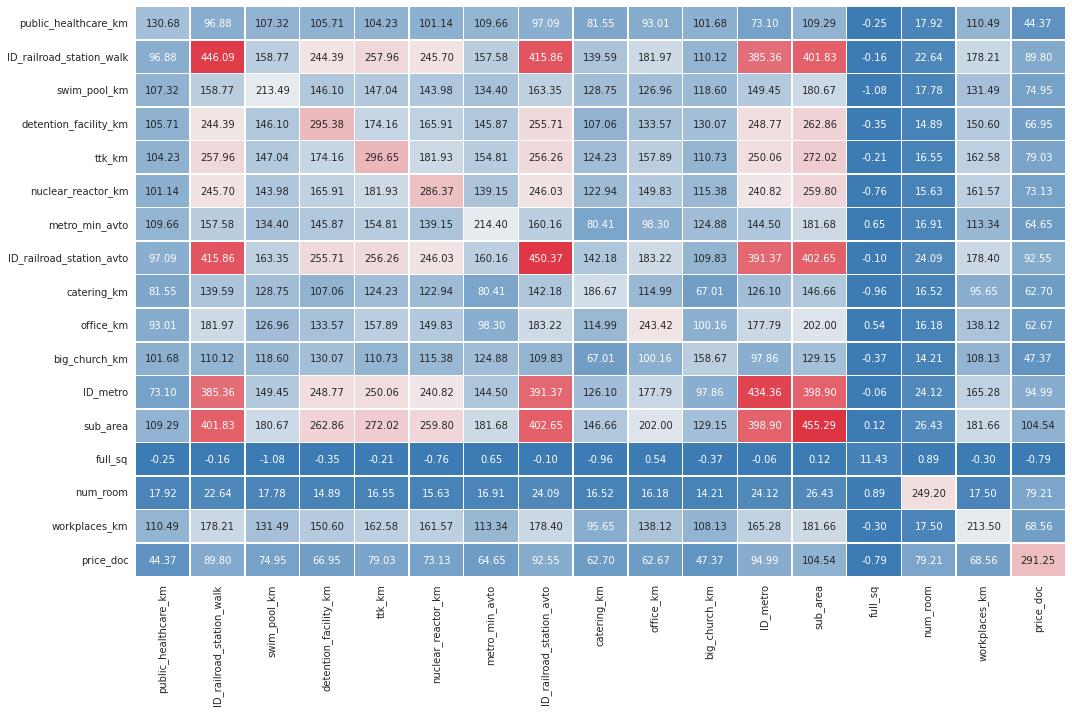

In [119]:
plot_corr_matrix(significance_overview, (15,10), cbar=False)

Видно влияние логически связанных между собой признаков, например, ```ID_raillroard_station_walk``` коррелирует с ```sub_area, ID_metro, ID_railroad_station_avto``` и т.д. Вероятно их нужно тестировать в прямом отборе на модели

# **6. Подготовка тестовых данных**

Рассмотрим пропуски в тестовом наборе данных:

In [390]:
features_with_na_test = df_test.isna().sum().where(df_test.isna().sum() > 0).dropna().to_frame('NA_count').reset_index()
features_with_na_test['NA_ratio'] = round(features_with_na_test['NA_count'] / df_test.shape[0], 3)
features_with_na_test.rename(columns={'index': 'feature'}, inplace=True)

In [391]:
features_with_na_test.sort_values(by='NA_ratio', ascending=False)

feature  NA_count  NA_ratio
6                     hospital_beds_raion    3418.0     0.446
29             cafe_sum_500_max_price_avg    3159.0     0.412
30                     cafe_avg_price_500    3159.0     0.412
28             cafe_sum_500_min_price_avg    3159.0     0.412
4                         preschool_quota    1596.0     0.208
5                            school_quota    1595.0     0.208
15                       build_count_slag    1218.0     0.159
22                 build_count_after_1995    1218.0     0.159
21                  build_count_1971-1995    1218.0     0.159
20                  build_count_1946-1970    1218.0     0.159
31            cafe_sum_1000_min_price_avg    1222.0     0.159
18                build_count_before_1920    1218.0     0.159
17  raion_build_count_with_builddate_info    1218.0     0.159
16                        build_count_mix    1218.0     0.159
19                  build_count_1921-1945    1218.0     0.159
14                       build_count_foam    1218.0     0.159
13                      build_count_panel    1218.0     0.159
11                      build_count_brick    1218.0     0.159
10                      build_count_frame    1218.0     0.159
9                        build_count_wood    1218.0     0.159
8                       build_count_block    1218.0     0.159
7    raion_build_count_with_material_info    1218.0     0.159
32            cafe_sum_1000_max_price_avg    1222.0     0.159
33                    cafe_avg_price_1000    1222.0     0.159
12                   build_count_monolith    1218.0     0.159
0                                 life_sq    1176.0     0.153
1                              build_year    1049.0     0.137
34            cafe_sum_1500_min_price_avg     821.0     0.107
35            cafe_sum_1500_max_price_avg     821.0     0.107
36                    cafe_avg_price_1500     821.0     0.107
2                                   state     694.0     0.091
39            cafe_sum_2000_max_price_avg     424.0     0.055
40                    cafe_avg_price_2000     424.0     0.055
38            cafe_sum_2000_min_price_avg     424.0     0.055
42            cafe_sum_3000_max_price_avg     182.0     0.024
41            cafe_sum_3000_min_price_avg     182.0     0.024
43                    cafe_avg_price_3000     182.0     0.024
45            cafe_sum_5000_min_price_avg     128.0     0.017
46            cafe_sum_5000_max_price_avg     128.0     0.017
47                    cafe_avg_price_5000     128.0     0.017
44                         prom_part_5000      92.0     0.012
27               ID_railroad_station_walk      34.0     0.004
26              railroad_station_walk_min      34.0     0.004
25               railroad_station_walk_km      34.0     0.004
23                         metro_min_walk      34.0     0.004
3                            product_type      33.0     0.004
24                          metro_km_walk      34.0     0.004
37                        green_part_2000      19.0     0.002

Применим к ним те же самые преобразования, что и к тренировочному набору данных:

In [376]:
to_zero = ['cafe_avg_price_1000', 'cafe_avg_price_1500', 'cafe_avg_price_2000',
           'cafe_avg_price_3000', 'cafe_avg_price_5000', 'cafe_sum_1000_max_price_avg',
           'cafe_sum_1000_min_price_avg', 'cafe_sum_1500_max_price_avg',
           'cafe_sum_1500_min_price_avg', 'cafe_sum_2000_max_price_avg',
           'cafe_sum_2000_min_price_avg', 'cafe_sum_3000_max_price_avg',
           'cafe_sum_3000_min_price_avg', 'cafe_sum_5000_max_price_avg',
           'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
           'cafe_avg_price_500', 'green_part_2000',
           'cafe_sum_5000_min_price_avg','raion_build_count_with_builddate_info',
           'raion_build_count_with_material_info', 'kitch_sq',
           'build_year', 'state']

to_median = ['prom_part_5000', 'floor', 'metro_min_walk', 'railroad_station_walk_min',
             'railroad_station_walk_km', 'metro_km_walk', 'num_room', 'max_floor',
             'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995',
             'build_count_after_1995', 'build_count_before_1920', 'build_count_block',
             'build_count_brick', 'build_count_foam', 'build_count_frame',
             'build_count_mix', 'build_count_monolith', 'build_count_panel',
             'build_count_slag', 'build_count_wood',
             'hospital_beds_raion']

to_mean= ['preschool_quota', 'school_quota']

to_freq = ['ID_railroad_station_walk', 'material', 'product_type']

In [392]:
df_test[to_zero] = df_test[to_zero].fillna(0)
df_test[to_median] = df_test[to_median].fillna(df_test[to_median].median())
df_test[to_mean] = df_test[to_mean].fillna(df_test[to_mean].mean())
df_test[to_freq] = df_test[to_freq].fillna(df_test[to_freq].mode().iloc[0])
df_test.loc[df_test.life_sq.isna(), 'life_sq'] = df_test.loc[df_test.life_sq.isna(), 'full_sq']
df_train.loc[df_train.kitch_sq > df_train.full_sq, 'kitch_sq'] = 0
df_train.loc[df_train.full_sq < 10, 'full_sq'] = df_train.loc[df_train.full_sq < 10, 'life_sq']
df_train.loc[df_train.life_sq > df_train.full_sq, 'life_sq'] = df_train.loc[df_train.life_sq > df_train.full_sq, 'full_sq']

In [393]:
df_test.isna().sum().sum()

0

Преобразуем типы:

In [394]:
df_test_typified = dataset_preparation(
    df_test,
    binary_features,
    unordered_cat_teatures,
    ordered_cat_features,
    features_types.pop(target, features_types))

Также удаляем из тестового набора признаки, удаленного из тренировочного:

In [405]:
id = df_test.id

In [406]:
cols_to_drop = set(df_test_typified.columns).difference(set(df_train_typified_outlier.columns))
df_test_typified = df_test_typified.drop(columns=cols_to_drop)
df_train_typified_outlier.shape, df_test_typified.shape

((30464, 118), (7662, 117))

Тестовый датасет готов

# **7. Моделирование**

Копируем датасеты для ускорения дальнешей настройки моделей:

In [396]:
df_train_to_model = df_train_typified_outlier.copy()
df_test_to_model = df_test_typified.copy()

Выделяем валидационную выборку:

In [209]:
train_X, val_X, train_y, val_y = train_test_split(
    df_train_to_model.drop(columns=target),
    df_train_to_model[target],
    train_size=0.9,
    random_state=123)

print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)

(27417, 117) (27417,)
(3047, 117) (3047,)


#### **LightGBM**

In [285]:
model_lb = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_lb, train_X, train_y, scoring='neg_mean_squared_log_error', cv=cv, n_jobs=-1, error_score='raise')
print('NMSLE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

NMSLE: -0.001 (0.000)


In [329]:
model_lb.fit(train_X, train_y)
y_pred_lb = model_lb.predict(train_X)

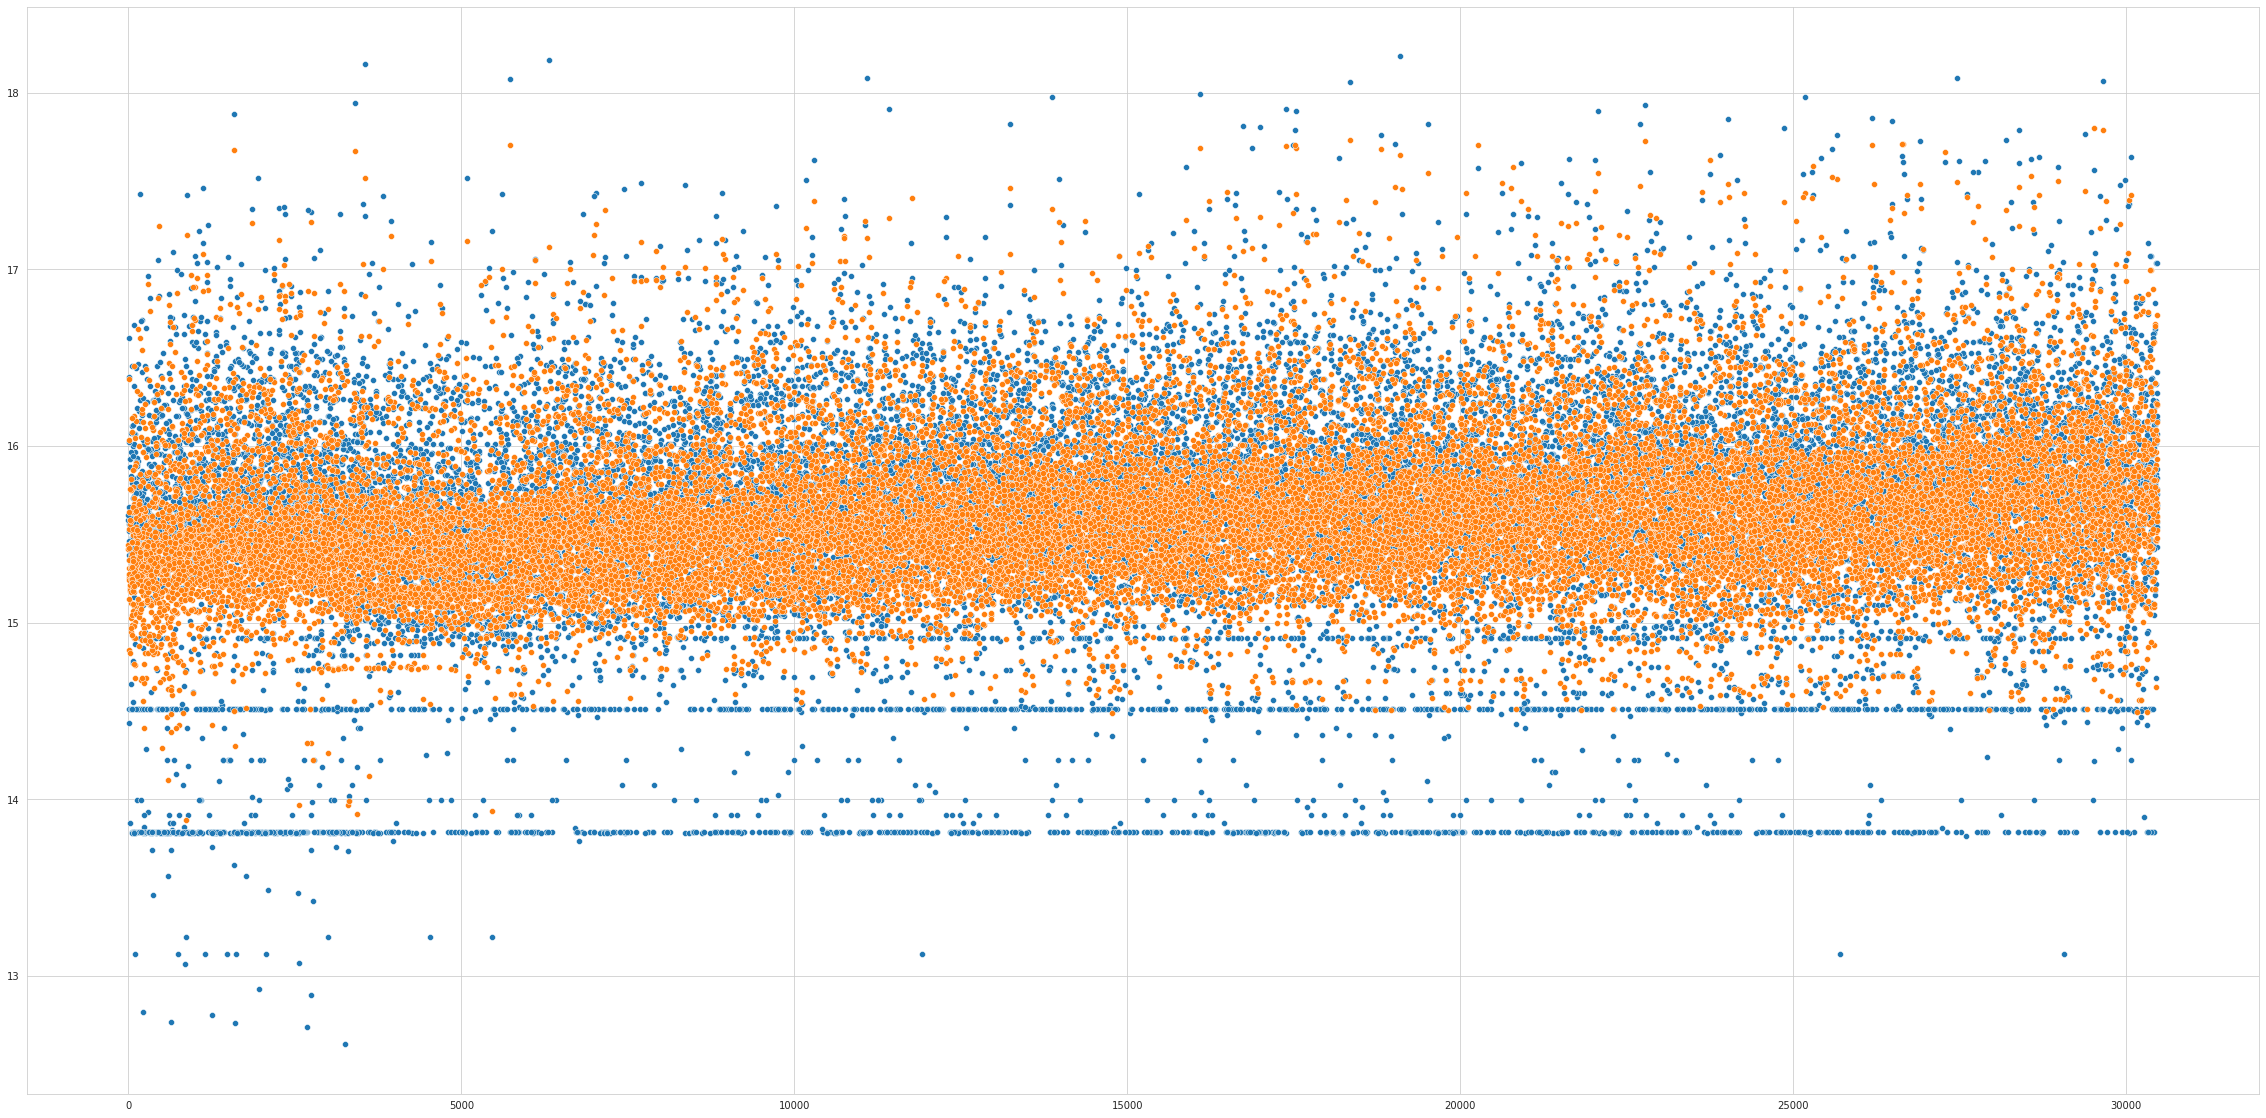

In [330]:
plt.figure(figsize=(40, 20))
sns.scatterplot(y=train_y.values, x=train_y.index)
sns.scatterplot(y=y_pred_lb, x=train_y.index)

In [344]:
explainer = shap.TreeExplainer(model_lb)
shap_values = explainer.shap_values(train_X)

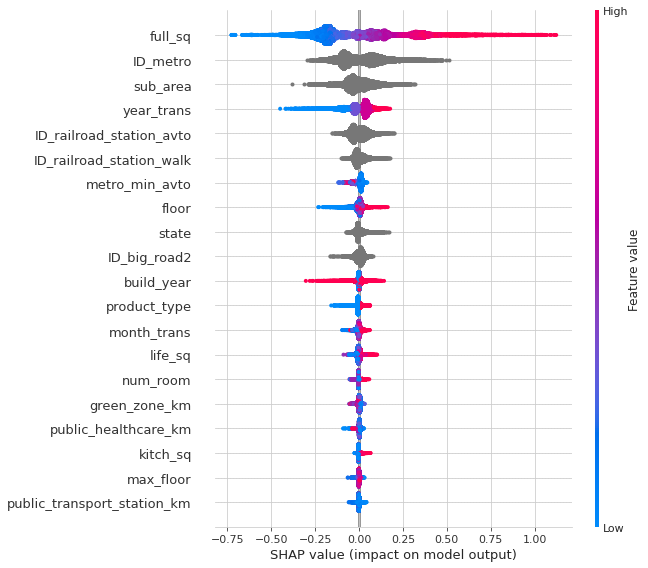

In [345]:
shap.summary_plot(shap_values, train_X)

In [407]:
predict = np.exp(model_lb.predict(df_test_to_model))
submission = pd.DataFrame({'id': id, 'price_doc': predict})
submission.head()

id     price_doc
0  30474  5.228103e+06
1  30475  8.755773e+06
2  30476  4.535298e+06
3  30477  6.802117e+06
4  30478  5.439341e+06

In [408]:
submission.shape

(7662, 2)

In [409]:
submission.to_csv('LightGBM.csv', index=False)

#### **CatBoost**

In [297]:
# cat_features = list(ordered_cat_features.keys()) + unordered_cat_teatures
cat_features = list(ordered_cat_features.keys()) + unordered_cat_teatures + ['material']

In [298]:
train_pool = catboost.Pool(
    train_X,
    label=train_y,
    cat_features=cat_features
)
val_pool = catboost.Pool(
    val_X,
    label=val_y,
    cat_features=cat_features
)
test_pool = catboost.Pool(
    df_test_to_model,
    # label=test_y,
    cat_features=cat_features
)

In [302]:
model_cb = catboost.CatBoostRegressor(
    loss_function='RMSE',
    depth=10,
    verbose=1, 
    n_estimators=1000,
    random_seed=123,
    task_type='GPU',
    # use_best_model=True,
    cat_features=cat_features
)

grid = {'depth': [10, 100, 1000, 2000],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        # 'learning_rate': [0.03, 0.1],
        }

grid_search_result = model_cb.grid_search(grid, 
                                       X=train_X, 
                                       y=train_y, 
                                       cv=cv,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Выходные данные были обрезаны до нескольких последних строк (5000).
14:	learn: 9.9171752	test: 9.9097979	best: 9.9097979 (14)	total: 1.74s	remaining: 1m 54s
15:	learn: 9.6212773	test: 9.6138413	best: 9.6138413 (15)	total: 1.79s	remaining: 1m 50s
16:	learn: 9.3350480	test: 9.3276112	best: 9.3276112 (16)	total: 1.93s	remaining: 1m 51s
17:	learn: 9.0571933	test: 9.0494834	best: 9.0494834 (17)	total: 2.09s	remaining: 1m 53s
18:	learn: 8.7874897	test: 8.7795982	best: 8.7795982 (18)	total: 2.24s	remaining: 1m 55s
19:	learn: 8.5259545	test: 8.5181224	best: 8.5181224 (19)	total: 2.39s	remaining: 1m 57s
20:	learn: 8.2724721	test: 8.2644413	best: 8.2644413 (20)	total: 2.54s	remaining: 1m 58s
21:	learn: 8.0256876	test: 8.0175901	best: 8.0175901 (21)	total: 2.56s	remaining: 1m 53s
22:	learn: 7.7869679	test: 7.7786790	best: 7.7786790 (22)	total: 2.68s	remaining: 1m 53s
23:	learn: 7.5553121	test: 7.5469246	best: 7.5469246 (23)	total: 2.82s	remaining: 1m 54s
24:	learn: 7.3303878	test: 7.3221015	best:

In [ ]:
model_cb.best_score_

{'learn': {'RMSE': 0.41564961089134955}}

```{'learn': {'RMSE': 0.41564961089134955}}```

In [304]:
model_cb.get_params()

{'cat_features': ['ecology',
  'state',
  'sub_area',
  'material',
  'ID_metro',
  'ID_railroad_station_walk',
  'ID_railroad_station_avto',
  'ID_big_road1',
  'ID_big_road2',
  'ID_railroad_terminal',
  'ID_bus_terminal',
  'material'],
 'depth': 10,
 'l2_leaf_reg': 5,
 'loss_function': 'RMSE',
 'n_estimators': 1000,
 'random_seed': 123,
 'task_type': 'GPU',
 'verbose': 1}

```
{'cat_features': ['ecology',
  'state',
  'sub_area',
  'material',
  'ID_metro',
  'ID_railroad_station_walk',
  'ID_railroad_station_avto',
  'ID_big_road1',
  'ID_big_road2',
  'ID_railroad_terminal',
  'ID_bus_terminal',
  'material'],
 'depth': 10,
 'l2_leaf_reg': 5,
 'loss_function': 'RMSE',
 'n_estimators': 1000,
 'random_seed': 123,
 'task_type': 'GPU',
 'verbose': 1}
 ```

In [305]:
model_cb.get_all_params()

{'add_ridge_penalty_to_loss_function': False,
 'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'border_count': 128,
 'classes_count': 0,
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'counter_calc_method': 'SkipTest',
 'ctr_history_unit': 'Sample',
 'ctr_target_border_count': 1,
 'data_partition': 'FeatureParallel',
 'depth': 10,
 'devices': '-1',
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'fold_len_multiplier': 2,
 'fold_permutation_block': 64,
 'fold_size_loss_normalization': False,
 'force_unit_auto_pair_weights': False,
 'gpu_cat_features_storage': 'GpuRam',
 'gpu_ram_part': 0.95,
 'grow_policy': 'SymmetricTree',
 'has_

```
{'add_ridge_penalty_to_loss_function': False,
 'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'border_count': 128,
 'classes_count': 0,
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'counter_calc_method': 'SkipTest',
 'ctr_history_unit': 'Sample',
 'ctr_target_border_count': 1,
 'data_partition': 'FeatureParallel',
 'depth': 10,
 'devices': '-1',
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'fold_len_multiplier': 2,
 'fold_permutation_block': 64,
 'fold_size_loss_normalization': False,
 'force_unit_auto_pair_weights': False,
 'gpu_cat_features_storage': 'GpuRam',
 'gpu_ram_part': 0.95,
 'grow_policy': 'SymmetricTree',
 'has_time': False,
 'iterations': 1000,
 'l2_leaf_reg': 5,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.029999999329447743,
 'loss_function': 'RMSE',
 'max_ctr_complexity': 4,
 'max_leaves': 1024,
 'meta_l2_exponent': 1,
 'meta_l2_frequency': 0,
 'min_data_in_leaf': 1,
 'min_fold_size': 100,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'observations_to_bootstrap': 'TestOnly',
 'one_hot_max_size': 2,
 'permutation_count': 4,
 'pinned_memory_bytes': '104857600',
 'pool_metainfo_options': {'tags': {}},
 'random_seed': 123,
 'random_strength': 1,
 'rsm': 1,
 'score_function': 'Cosine',
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=MinEntropy:Prior=0/1'],
 'task_type': 'GPU',
 'use_best_model': False}
```

In [314]:
p_t = {'add_ridge_penalty_to_loss_function': False,
 'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'border_count': 128,
 'classes_count': 0,
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'counter_calc_method': 'SkipTest',
 'ctr_history_unit': 'Sample',
 'ctr_target_border_count': 1,
 'data_partition': 'FeatureParallel',
 'depth': 10,
 'devices': '-1',
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'fold_len_multiplier': 2,
 'fold_permutation_block': 64,
 'fold_size_loss_normalization': False,
 'force_unit_auto_pair_weights': False,
 'gpu_cat_features_storage': 'GpuRam',
 'gpu_ram_part': 0.95,
 'grow_policy': 'SymmetricTree',
 'has_time': False,
 'iterations': 1000,
 'l2_leaf_reg': 5,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.029999999329447743,
 'loss_function': 'RMSE',
 'max_ctr_complexity': 4,
 'max_leaves': 1024,
 'meta_l2_exponent': 1,
 'meta_l2_frequency': 0,
 'min_data_in_leaf': 1,
 'min_fold_size': 100,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'observations_to_bootstrap': 'TestOnly',
 'one_hot_max_size': 2,
 'permutation_count': 4,
 'pinned_memory_bytes': '104857600',
 'pool_metainfo_options': {'tags': {}},
 'random_seed': 123,
 'random_strength': 1,
 'rsm': 1,
 'score_function': 'Cosine',
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=MinEntropy:Prior=0/1'],
 'task_type': 'GPU',
 'use_best_model': False}

In [315]:
# model_cb = catboost.CatBoostRegressor(
#     loss_function='RMSE',
#     depth=10,
#     verbose=1, 
#     n_estimators=1000,
#     random_seed=123,
#     task_type='GPU',
#     use_best_model=True
# )
model_cb.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5972153	test: 0.5923980	best: 0.5923980 (0)	total: 181ms	remaining: 3m
1:	learn: 0.5915796	test: 0.5865697	best: 0.5865697 (1)	total: 365ms	remaining: 3m 2s
2:	learn: 0.5860685	test: 0.5808780	best: 0.5808780 (2)	total: 535ms	remaining: 2m 57s
3:	learn: 0.5808184	test: 0.5754878	best: 0.5754878 (3)	total: 688ms	remaining: 2m 51s
4:	learn: 0.5759542	test: 0.5704520	best: 0.5704520 (4)	total: 866ms	remaining: 2m 52s
5:	learn: 0.5711393	test: 0.5654157	best: 0.5654157 (5)	total: 1.03s	remaining: 2m 51s
6:	learn: 0.5664453	test: 0.5605792	best: 0.5605792 (6)	total: 1.21s	remaining: 2m 51s
7:	learn: 0.5622272	test: 0.5561710	best: 0.5561710 (7)	total: 1.39s	remaining: 2m 52s
8:	learn: 0.5579594	test: 0.5517257	best: 0.5517257 (8)	total: 1.56s	remaining: 2m 52s
9:	learn: 0.5540008	test: 0.5476227	best: 0.5476227 (9)	total: 1.72s	remaining: 2m 50s
10:	learn: 0.5502237	test: 0.5437262	best: 0.5437262 (10)	total: 1.89s	remaining: 2m 50s
11:	learn: 0.5466414	test: 0.5400187	best: 0.5

In [331]:
y_pred_cb = model_cb.predict(train_X)

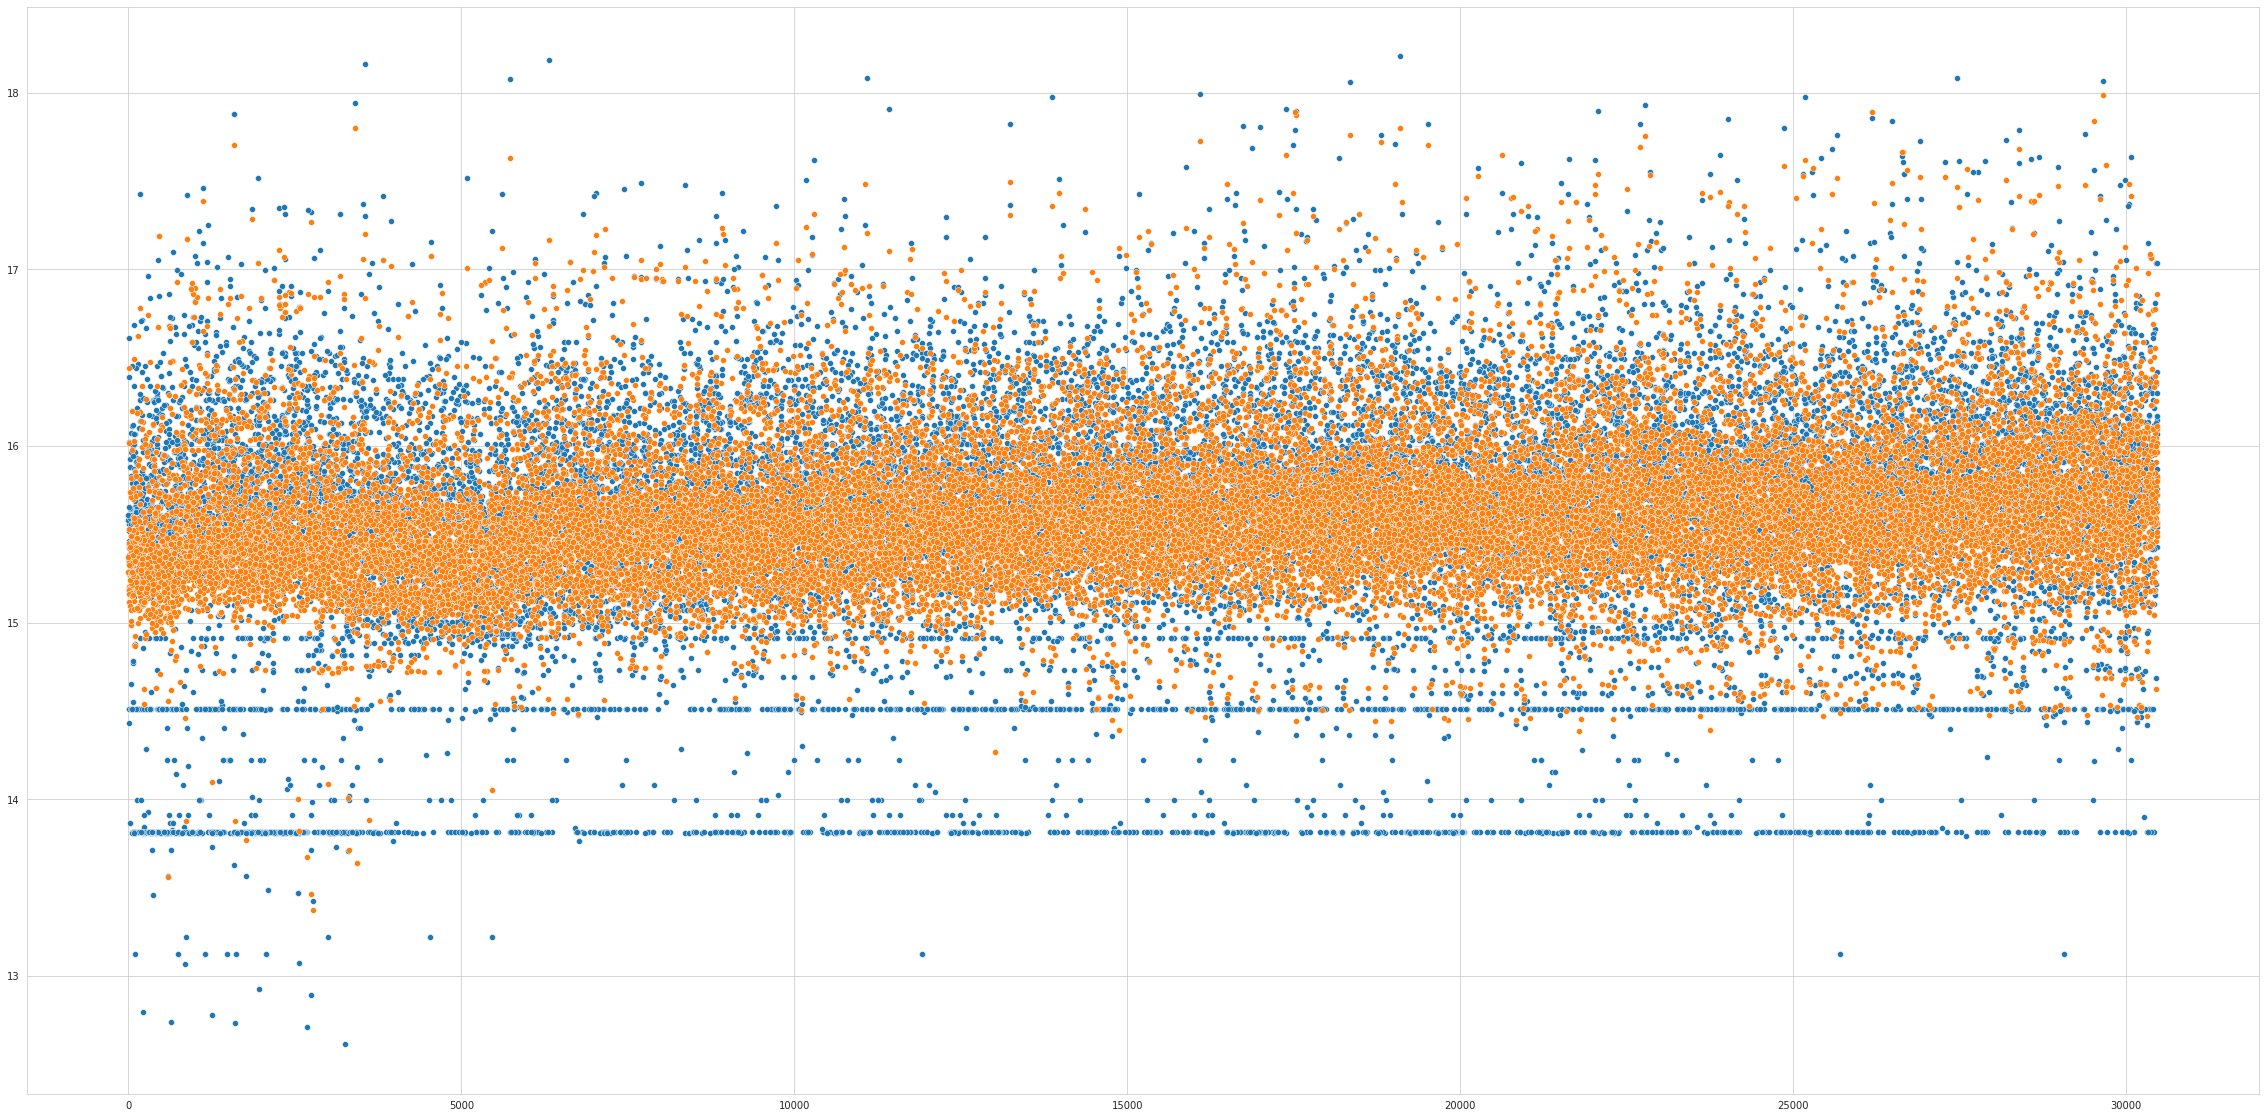

In [332]:
plt.figure(figsize=(40, 20))
sns.scatterplot(y=train_y.values, x=train_y.index)
sns.scatterplot(y=y_pred_cb, x=train_y.index)

In [328]:
shap_info = model_cb.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]

Processing trees...
128/993 trees processed	passed time: 6.37s	remaining time: 43s
993/993 trees processed	passed time: 43.3s	remaining time: 0us
Processing documents...
128/27417 documents processed	passed time: 17.7ms	remaining time: 3.78s
10112/27417 documents processed	passed time: 1.12s	remaining time: 1.92s
20096/27417 documents processed	passed time: 2.17s	remaining time: 790ms
27417/27417 documents processed	passed time: 2.94s	remaining time: 0us


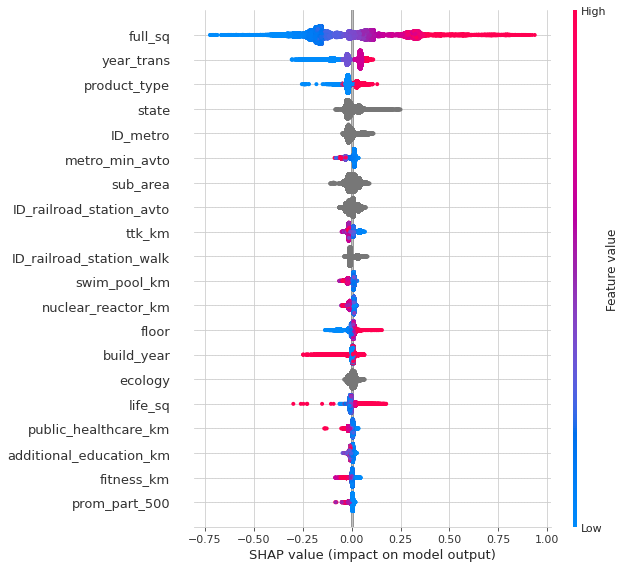

In [333]:
shap.summary_plot(shap_values, train_X)

In [404]:
df_test_to_model

full_sq  life_sq  floor  ...  year_trans month_trans  day_trans
0       39.00    20.70      2  ...        2015           7          1
1       79.20    79.20      8  ...        2015           7          1
2       40.50    25.10      3  ...        2015           7          1
3       62.80    36.00     17  ...        2015           7          1
4       40.00    40.00     17  ...        2015           7          1
...       ...      ...    ...  ...         ...         ...        ...
7657    52.20    31.80     10  ...        2016           5         26
7658    54.09    54.09     14  ...        2016           5         28
7659    41.08     1.00     12  ...        2016           5         30
7660    34.80    19.80      8  ...        2016           5         30
7661    63.00    43.80      5  ...        2016           5         30

[7662 rows x 117 columns]

In [410]:
predict = np.exp(model_cb.predict(df_test_to_model))
submission = pd.DataFrame({'id': id, 'price_doc': predict})
submission.head()

id     price_doc
0  30474  5.478235e+06
1  30475  9.016887e+06
2  30476  5.079850e+06
3  30477  6.397148e+06
4  30478  5.384201e+06

In [411]:
submission.shape

(7662, 2)

In [412]:
submission.to_csv('Catboost.csv', index=False)

# **8. Scores**

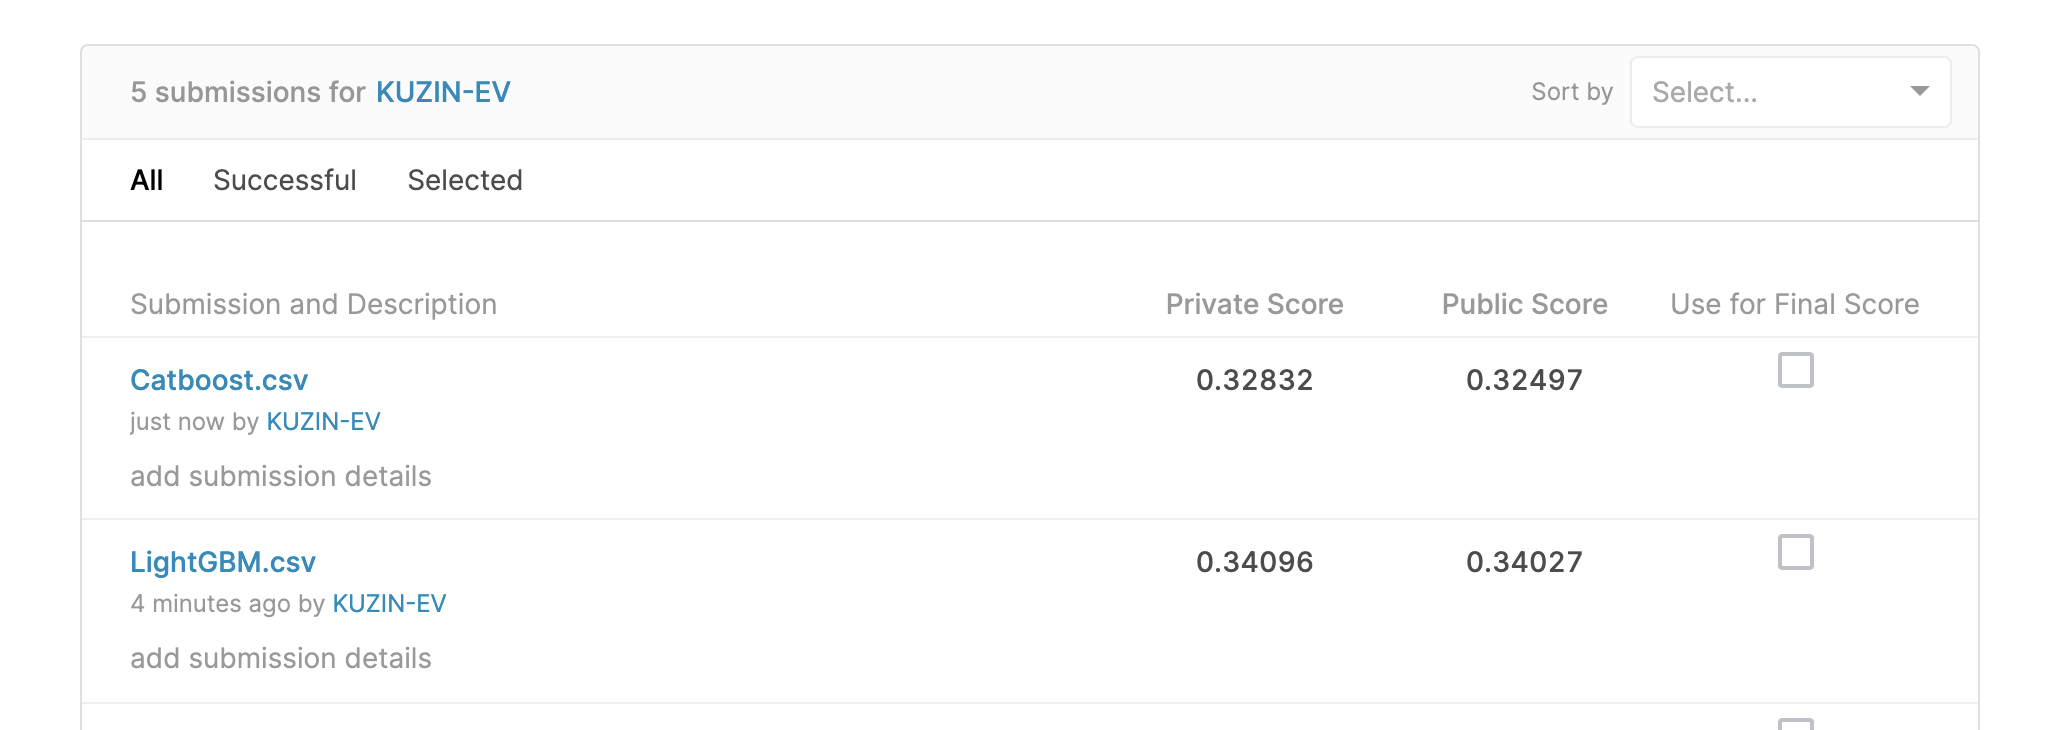

https://drive.google.com/file/d/1JFE-cSmWJGrchJOhsP1BXnjEX26_iFlW/view?usp=sharing

Интересно, что LightGBM отлично сработал "из коробки", а с CatBoost помог встроенный поиск по сетки. Нужно отдать должное реализации этого метода, т.к. он работает за очень приемлемое время, в отличие от sklearn GridSearchCV